In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import math
import statistics
import random

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, homogeneity_score

from collections import Counter

# Functions

In [2]:
def id_to_cluster(linkage_data, agg_features_df):
    """
    linkage_data: array of cluster numbers
    agg_features_df: df of aggregated features to merge, index must match order of linkage_data
    Returns a df with aggregated cp data and cluster number for each id
    """
    # Get cluster number with the aggregated feature data
    clusters_hierarchal_df = pd.DataFrame(data=linkage_data, index=agg_features_df.index)
    clusters_hierarchal_df.rename(columns={0:'cluster_num'}, inplace=True)
    clusters_hierarchal_df = clusters_hierarchal_df.merge(agg_features_df, how='left', left_index=True, right_index=True)

    # Get the cell profiler features by cluster
    cp_features_by_cluster = clusters_hierarchal_df.groupby(by='cluster_num').mean()
    
    return clusters_hierarchal_df

def hierarchical_cluster(df, threshold, show=False):
    """
    Returns df of cluster features
    """
    threshold=threshold
    Z1 = linkage(df, 'ward')
    flat_linkage1 = fcluster(Z1, t=threshold, criterion='distance')
    cluster_features1 = id_to_cluster(flat_linkage1, df)
    
    if show:
        plt.figure(figsize=(12, df.shape[0]/4))
        plt.axvline(x=threshold)
        label = [str(i) + ' ' + j for i, j in zip(flat_linkage1.tolist(), df.index.tolist())]
        plt.title('Clusters based on cell profiler features')
        dend1 = dendrogram(Z1, color_threshold=threshold, orientation='left', leaf_font_size=10, labels=label)
    return cluster_features1

def km_cluster(df, num_clusters, random_state=2):
    """
    returns df of cluster features
    """
    km = KMeans(n_clusters=num_clusters, random_state=random_state).fit(df)
    return id_to_cluster(km.labels_, df)

In [3]:
def ttest_2_df(df1, df2, alpha=0.05, reject_only=True):
    """
    Inputs are 2 dataframes with the same column features. Returns FDR adjusted p-values for each feature.
    """
#     assert df1.columns == df2.columns
    z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
    p_df = pd.DataFrame(pvals, index = df1.columns)
    p_df = p_df.rename(columns={0: 'pval'}) # unadjusted p values
    
    # Remove first row, which is just a ttest on the column number
    p_df =  p_df.iloc[1:]
    
    # Get corrected p-values
    q_df = p_df
    q_df['adj_p_value'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[1]
    q_df['reject_null'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[0]
    
    if reject_only:
        q_df = q_df[q_df['reject_null'] == True]
    
    return q_df

# Load data

In [41]:
# Progenitors data
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

switch_isogenic_labels = True
human_only=True

#FS data
progenitors = pd.read_csv(base_dir + '/feature_sets/Progenitors/0714_stdev_corr_fs.csv', index_col=0)

# exclude = ['5', '6', '33', '12', '16']
try:
    idx = [i for i in progenitors.index.tolist() if i.split('_')[2] not in exclude] # Exclude patient number
    progenitors = progenitors[progenitors.index.isin(idx)]
except: pass

if human_only:
    progenitors = progenitors[progenitors.index.str.contains('human')]

print ('shape: {}'.format(progenitors.shape))

labels = progenitors.index.tolist()
if switch_isogenic_labels:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
progenitors.index = labels
progenitors_orig = progenitors.copy()

shape: (312, 508)


In [5]:
# STEM data
# Or use my FS data
stem = pd.read_csv(base_dir + '/feature_sets/STEM01/0621_stdev_corr_fs.csv', index_col=0)


try:
    idx = [i for i in stem.index.tolist() if i.split('_')[-1] not in exclude]
    stem = stem[stem.index.isin(idx)]
except: pass

if human_only:
    stem = stem[stem.index.str.contains('human')]
    
print ('shape: {}'.format(stem.shape))

labels = stem.index.tolist()
if switch_isogenic_labels:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
stem.index = labels
stem_orig = stem.copy()

shape: (352, 559)


# Logistic regression and decision trees

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans

In [7]:
stem['label'] = stem.index.str.split('_').map(lambda x: x[1])
stem_xtrain, stem_xtest, stem_ytrain, stem_ytest = train_test_split(stem.drop(['label'], axis=1), stem['label'], 
                                                                    test_size=0.3, random_state=4)
print(len(stem_xtrain) + len(stem_xtest))

logr1 = LogisticRegression(random_state=2, penalty='l2', C=1).fit(stem_xtrain, stem_ytrain)
print(logr1.score(stem_xtrain, stem_ytrain), logr1.score(stem_xtest, stem_ytest))
# print(logr1.score(stem_xtrain, stem_ytrain.sample(frac=1)), logr1.score(stem_xtest, stem_ytest.sample(frac=1)))

352
1.0 0.9811320754716981


In [8]:
progenitors['label'] = progenitors.index.str.split('_').map(lambda x: x[1])
progenitors_xtrain, progenitors_xtest, progenitors_ytrain, progenitors_ytest = train_test_split(progenitors.drop(['label'], axis=1), progenitors['label'], 
                                                                    test_size=0.3, random_state=4)
print(len(progenitors_xtrain) + len(progenitors_xtest))

logr2 = LogisticRegression(random_state=2, penalty='l2', C=1, max_iter=130).fit(progenitors_xtrain, progenitors_ytrain)
print(logr2.score(progenitors_xtrain, progenitors_ytrain), logr2.score(progenitors_xtest, progenitors_ytest))
# print(logr2.score(progenitors_xtrain, progenitors_ytrain.sample(frac=1)), logr2.score(progenitors_xtest, progenitors_ytest.sample(frac=1)))

312
1.0 0.8936170212765957


In [9]:
hclus_stem = hierarchical_cluster(stem.drop(['label'], axis=1), 200, show=False)
# hclus_prog = hierarchical_cluster(progenitors.drop('label', axis=1), 170, show=True)

# q = hclus_stem[hclus_stem['cluster_num']==2]
# q[q.index.str.contains('del')]

In [10]:
tree1 = DecisionTreeClassifier(random_state=0).fit(stem_xtrain, stem_ytrain)
print(tree1.score(stem_xtrain, stem_ytrain), tree1.score(stem_xtest, stem_ytest))
print(tree1.score(stem_xtrain, stem_ytrain.sample(frac=1)), tree1.score(stem_xtest, stem_ytest.sample(frac=1)))

1.0 0.8867924528301887
0.5365853658536586 0.5283018867924528


In [11]:
tree2 = DecisionTreeClassifier(random_state=0).fit(progenitors_xtrain, progenitors_ytrain)
print(tree2.score(progenitors_xtrain, progenitors_ytrain), tree2.score(progenitors_xtest, progenitors_ytest))
print(tree2.score(progenitors_xtrain, progenitors_ytrain.sample(frac=1)), tree2.score(progenitors_xtest, progenitors_ytest.sample(frac=1)))

1.0 0.7978723404255319
0.5045871559633027 0.4574468085106383


In [12]:
stem = stem.drop(['label'], axis=1)
progenitors = progenitors.drop(['label'], axis=1)

# Feature Importance

In [13]:
stem_feature_weights = pd.DataFrame(logr1.coef_[0], columns=['weight'], index=stem.columns)
stem_feature_weights.reindex(stem_feature_weights['weight'].abs().sort_values(ascending=False).index).head(15)

,weight
Cytoplasm_RadialDistribution_FracAtD_Brightfield_1of4,0.376724
Nuclei_Correlation_Correlation_DNA_Brightfield,0.330376
Cytoplasm_RadialDistribution_FracAtD_Brightfield_4of4,-0.321044
Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4,-0.298933
Cytoplasm_Texture_InfoMeas1_AGP_5_00,0.294242
Cytoplasm_Intensity_MADIntensity_ER,0.272893
Nuclei_Granularity_13_AGP,0.267854
Nuclei_AreaShape_Zernike_8_0,0.267473
Cytoplasm_AreaShape_Zernike_3_1,0.263257
Nuclei_RadialDistribution_RadialCV_DNA_1of4,-0.256021


In [14]:
stem_tree_feature_weights = pd.DataFrame(tree1.feature_importances_, columns=['weight'], index=stem.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(stem_tree_feature_weights.sort_values(by='weight', ascending=False).head(13))


,weight
Cells_Correlation_Overlap_Mito_AGP,0.623577
Cells_RadialDistribution_FracAtD_ER_4of4,0.093851
Cells_Correlation_Overlap_ER_Brightfield,0.071221
Nuclei_Correlation_Correlation_ER_AGP,0.045813
Cells_Intensity_LowerQuartileIntensity_ER,0.034422
Nuclei_Texture_Correlation_ER_10_00,0.032048
Nuclei_Texture_AngularSecondMoment_Brightfield_20_01,0.026615
Cells_Texture_InverseDifferenceMoment_ER_10_00,0.016117
Cells_Texture_SumAverage_ER_10_00,0.016114
Cells_Granularity_4_AGP,0.015826


In [15]:
ttest_stem = ttest_2_df(stem[stem.index.str.contains('control')], stem[stem.index.str.contains('deletion')])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ttest_stem.sort_values(by='adj_p_value').head(15))

,pval,adj_p_value,reject_null
Cells_Correlation_Overlap_Mito_AGP,3.009470e-59,1.679284e-56,True
Cells_RadialDistribution_RadialCV_Mito_1of4,4.669365e-52,1.302753e-49,True
Cells_Granularity_2_Mito,1.979959e-50,3.682724e-48,True
Cells_Correlation_Overlap_DNA_Mito,1.179112e-49,1.644861e-47,True
Cells_Correlation_Overlap_Mito_Brightfield,1.775965e-49,1.981977e-47,True
Cells_Granularity_10_RNA,1.270430e-44,1.181500e-42,True
Cells_Correlation_Overlap_ER_Brightfield,1.332095e-43,1.061870e-41,True
Cells_RadialDistribution_FracAtD_AGP_4of4,1.905957e-42,1.329405e-40,True
Cells_Granularity_10_ER,1.646781e-40,1.021004e-38,True
Nuclei_Intensity_MassDisplacement_Mito,2.122590e-40,1.184405e-38,True


In [16]:
progenitors_feature_weights = pd.DataFrame(logr2.coef_[0], columns=['weight'], index=progenitors.columns)
progenitors_feature_weights.reindex(progenitors_feature_weights['weight'].abs().sort_values(ascending=False).index)

,weight
Nuclei_Intensity_MassDisplacement_DNA,-0.814218
Cells_Correlation_Overlap_ER_AGP,0.788013
Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4,0.699329
Nuclei_RadialDistribution_RadialCV_RNA_1of4,0.683442
Nuclei_Granularity_7_DNA,0.656347
...,...
Cells_Correlation_K_Mito_Brightfield,-0.001867
Nuclei_Texture_InfoMeas2_Mito_5_00,0.001393
Cytoplasm_Texture_Correlation_RNA_20_00,0.001046
Cells_AreaShape_Zernike_6_4,-0.000614


In [17]:
progenitors_tree_feature_weights = pd.DataFrame(tree2.feature_importances_, columns=['weight'], index=progenitors.columns)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(progenitors_tree_feature_weights.sort_values(by='weight', ascending=False).head(13))

,weight
Cells_Texture_Correlation_RNA_20_01,0.300669
Cells_Correlation_Correlation_DNA_ER,0.144459
Cells_RadialDistribution_RadialCV_ER_1of4,0.129482
Cells_Correlation_Overlap_ER_RNA,0.093956
Cells_RadialDistribution_RadialCV_Brightfield_4of4,0.081476
Nuclei_Texture_DifferenceEntropy_Mito_20_00,0.059595
Cells_Texture_Correlation_Brightfield_5_00,0.045888
Cytoplasm_Texture_InfoMeas1_AGP_10_00,0.038485
Cells_Texture_InfoMeas2_Brightfield_10_00,0.029718
Cytoplasm_AreaShape_Zernike_7_1,0.018326


In [18]:
ttest_progenitors = ttest_2_df(progenitors[progenitors.index.str.contains('control')], progenitors[progenitors.index.str.contains('deletion')])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ttest_progenitors.sort_values(by='adj_p_value'))

,pval,adj_p_value,reject_null
Cells_RadialDistribution_RadialCV_Brightfield_4of4,7.667327e-22,3.887335e-19,True
Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4,3.748944e-21,9.503573e-19,True
Nuclei_Granularity_6_DNA,1.139798e-17,1.926258e-15,True
Cells_Texture_Correlation_ER_20_01,2.949919e-17,3.739023e-15,True
Cells_Texture_Correlation_RNA_20_01,7.887897e-17,7.998328e-15,True
Cells_Correlation_Overlap_ER_AGP,1.290547e-16,1.090512e-14,True
Cells_Texture_InfoMeas1_AGP_20_01,1.737857e-16,1.258705e-14,True
Cells_Texture_Correlation_DNA_10_00,4.916551e-16,3.115864e-14,True
Nuclei_Granularity_7_DNA,9.173023e-16,5.167469e-14,True
Nuclei_Correlation_K_RNA_Brightfield,1.489581e-15,7.552176e-14,True


# Feature distribution figures

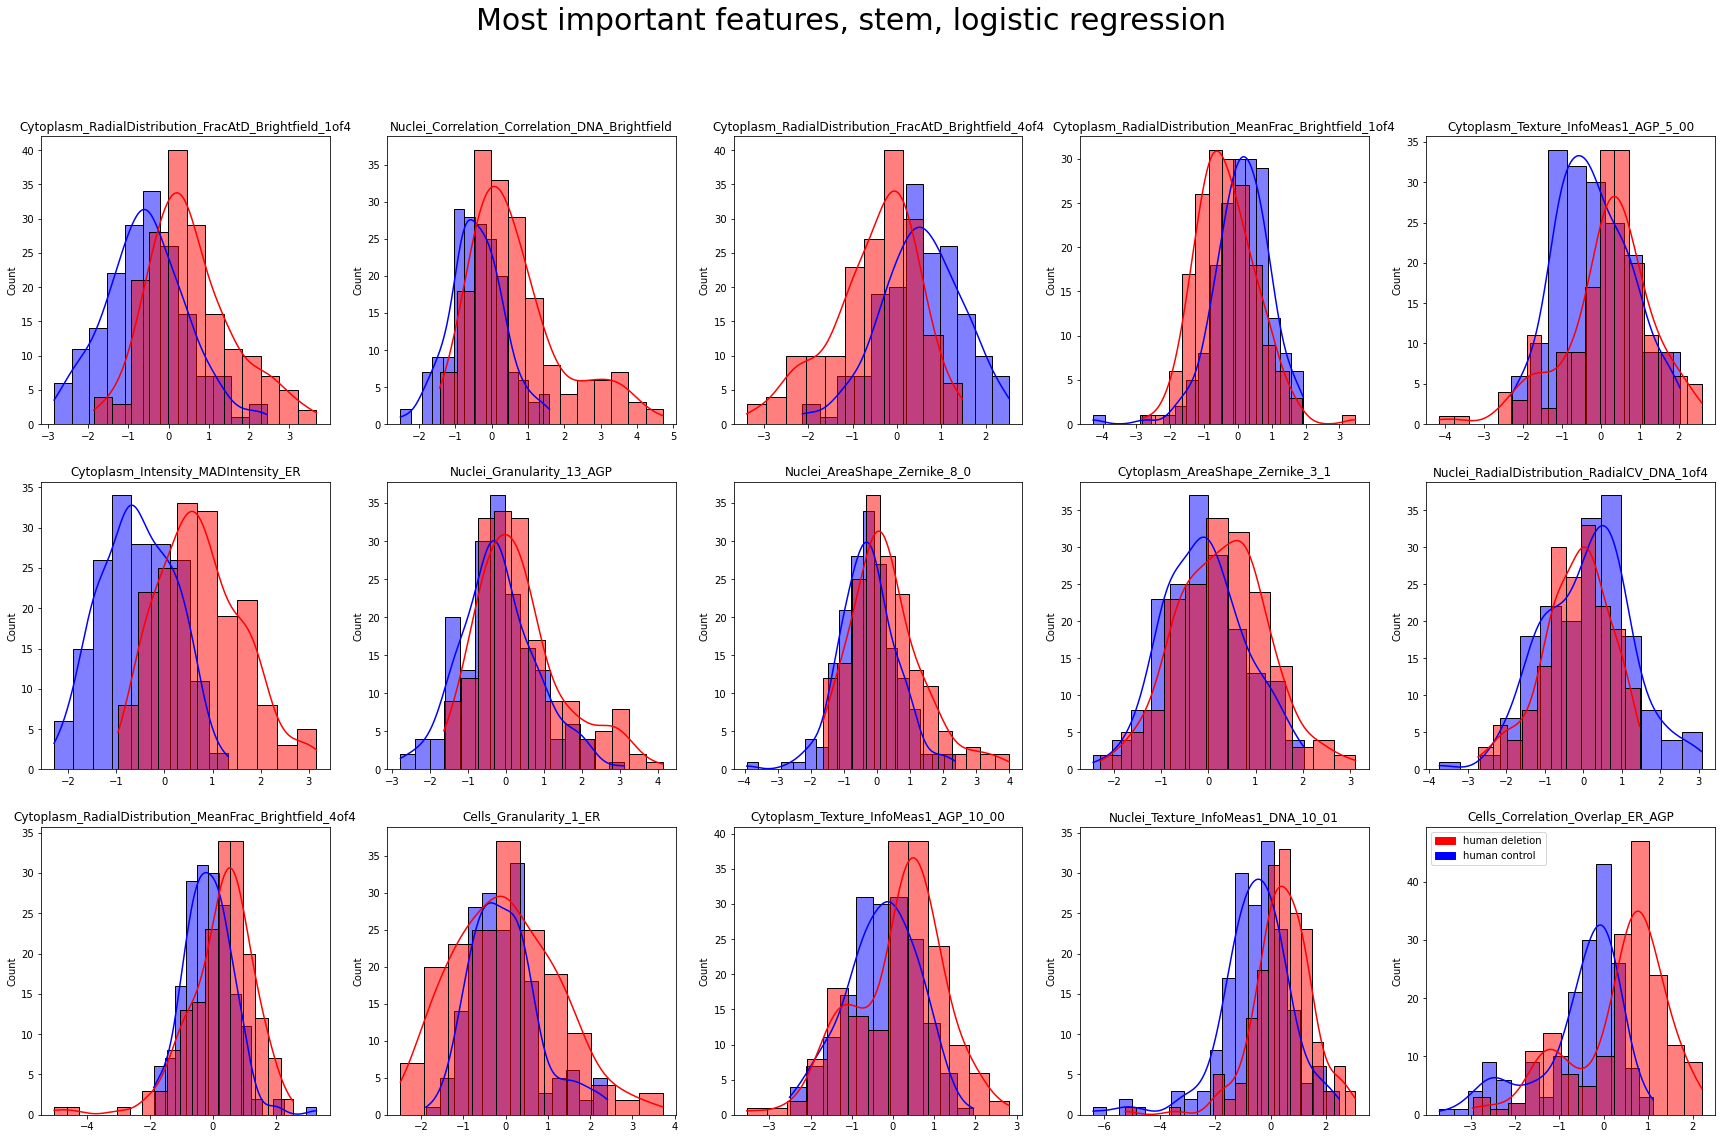

In [19]:
# Stem logistic

features = ['Cytoplasm_RadialDistribution_FracAtD_Brightfield_1of4',
 'Nuclei_Correlation_Correlation_DNA_Brightfield',
 'Cytoplasm_RadialDistribution_FracAtD_Brightfield_4of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4',
 'Cytoplasm_Texture_InfoMeas1_AGP_5_00',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Nuclei_Granularity_13_AGP',
 'Nuclei_AreaShape_Zernike_8_0',
 'Cytoplasm_AreaShape_Zernike_3_1',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Granularity_1_ER',
 'Cytoplasm_Texture_InfoMeas1_AGP_10_00',
 'Nuclei_Texture_InfoMeas1_DNA_10_01',
 'Cells_Correlation_Overlap_ER_AGP']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    ctrl_vals = human_ctrl_df[[feature]]
    del_vals = human_del_df[[feature]]
    
    sns.histplot(np.ravel(ctrl_vals), kde=True, ax=axs[row, col], color='blue')
    sns.histplot(np.ravel(del_vals), kde=True, ax=axs[row, col], color='red')
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
        
plt.suptitle('Most important features, stem, logistic regression', size=30)
plt.legend(handles=[mpatches.Patch(color='red', label='human deletion'), 
           mpatches.Patch(color='blue', label='human control')])

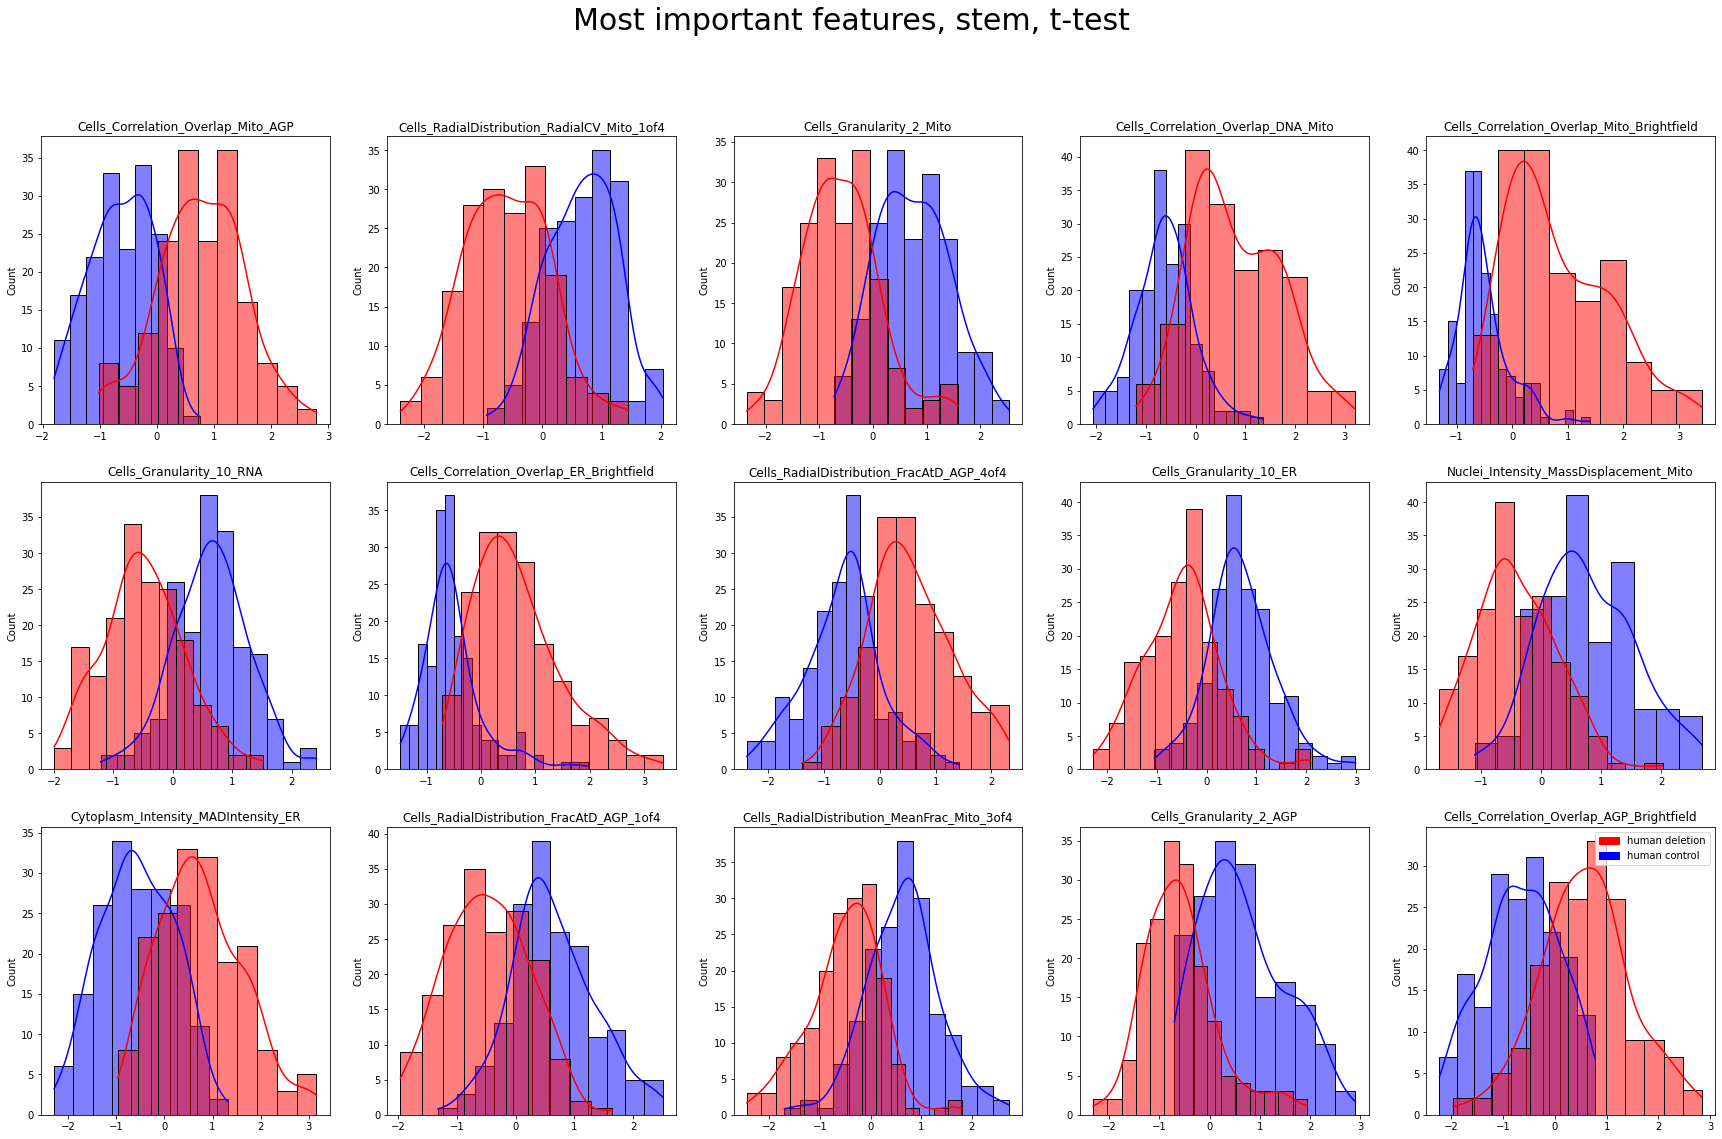

In [20]:
# Stem ttest

features = ['Cells_Correlation_Overlap_Mito_AGP',
 'Cells_RadialDistribution_RadialCV_Mito_1of4',
 'Cells_Granularity_2_Mito',
 'Cells_Correlation_Overlap_DNA_Mito',
 'Cells_Correlation_Overlap_Mito_Brightfield',
 'Cells_Granularity_10_RNA',
 'Cells_Correlation_Overlap_ER_Brightfield',
 'Cells_RadialDistribution_FracAtD_AGP_4of4',
 'Cells_Granularity_10_ER',
 'Nuclei_Intensity_MassDisplacement_Mito',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Cells_RadialDistribution_FracAtD_AGP_1of4',
 'Cells_RadialDistribution_MeanFrac_Mito_3of4',
 'Cells_Granularity_2_AGP',
 'Cells_Correlation_Overlap_AGP_Brightfield']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    ctrl_vals = human_ctrl_df[[feature]]
    del_vals = human_del_df[[feature]]
    
    sns.histplot(np.ravel(ctrl_vals), kde=True, ax=axs[row, col], color='blue')
    sns.histplot(np.ravel(del_vals), kde=True, ax=axs[row, col], color='red')
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
        
plt.suptitle('Most important features, stem, t-test', size=30)
plt.legend(handles=[mpatches.Patch(color='red', label='human deletion'), 
           mpatches.Patch(color='blue', label='human control')])

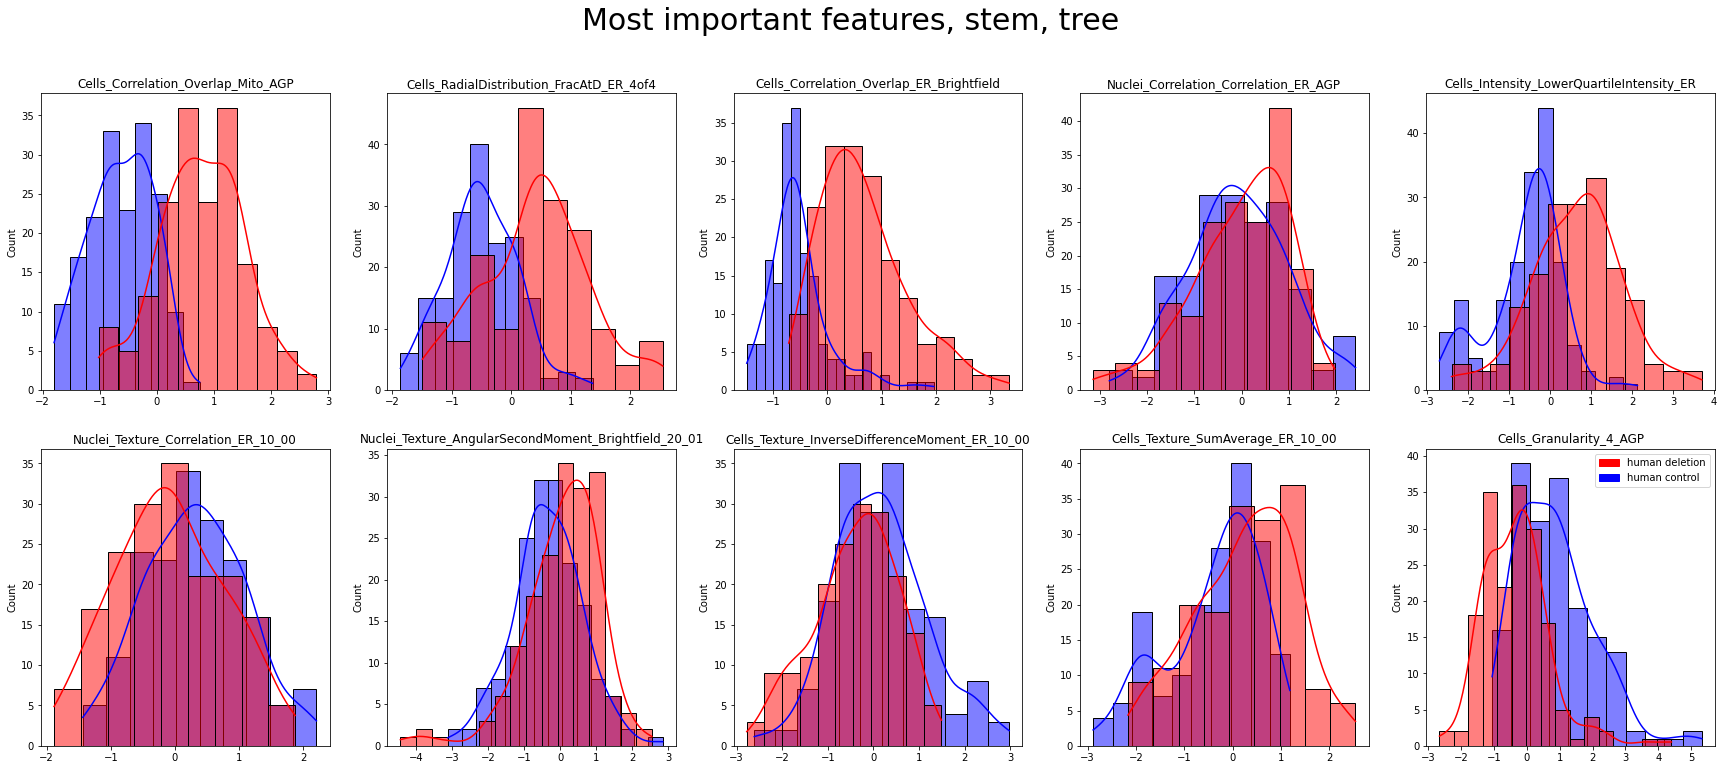

In [21]:
# Stem tree

features = ['Cells_Correlation_Overlap_Mito_AGP',
 'Cells_RadialDistribution_FracAtD_ER_4of4',
 'Cells_Correlation_Overlap_ER_Brightfield',
 'Nuclei_Correlation_Correlation_ER_AGP',
 'Cells_Intensity_LowerQuartileIntensity_ER',
 'Nuclei_Texture_Correlation_ER_10_00',
 'Nuclei_Texture_AngularSecondMoment_Brightfield_20_01',
 'Cells_Texture_InverseDifferenceMoment_ER_10_00',
 'Cells_Texture_SumAverage_ER_10_00',
 'Cells_Granularity_4_AGP']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(2,5, figsize=(30,12))
row = 0
col = 0
for feature in features:
    ctrl_vals = human_ctrl_df[[feature]]
    del_vals = human_del_df[[feature]]
    
    sns.histplot(np.ravel(ctrl_vals), kde=True, ax=axs[row, col], color='blue')
    sns.histplot(np.ravel(del_vals), kde=True, ax=axs[row, col], color='red')
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
        
plt.suptitle('Most important features, stem, tree', size=30)
plt.legend(handles=[mpatches.Patch(color='red', label='human deletion'), 
           mpatches.Patch(color='blue', label='human control')])

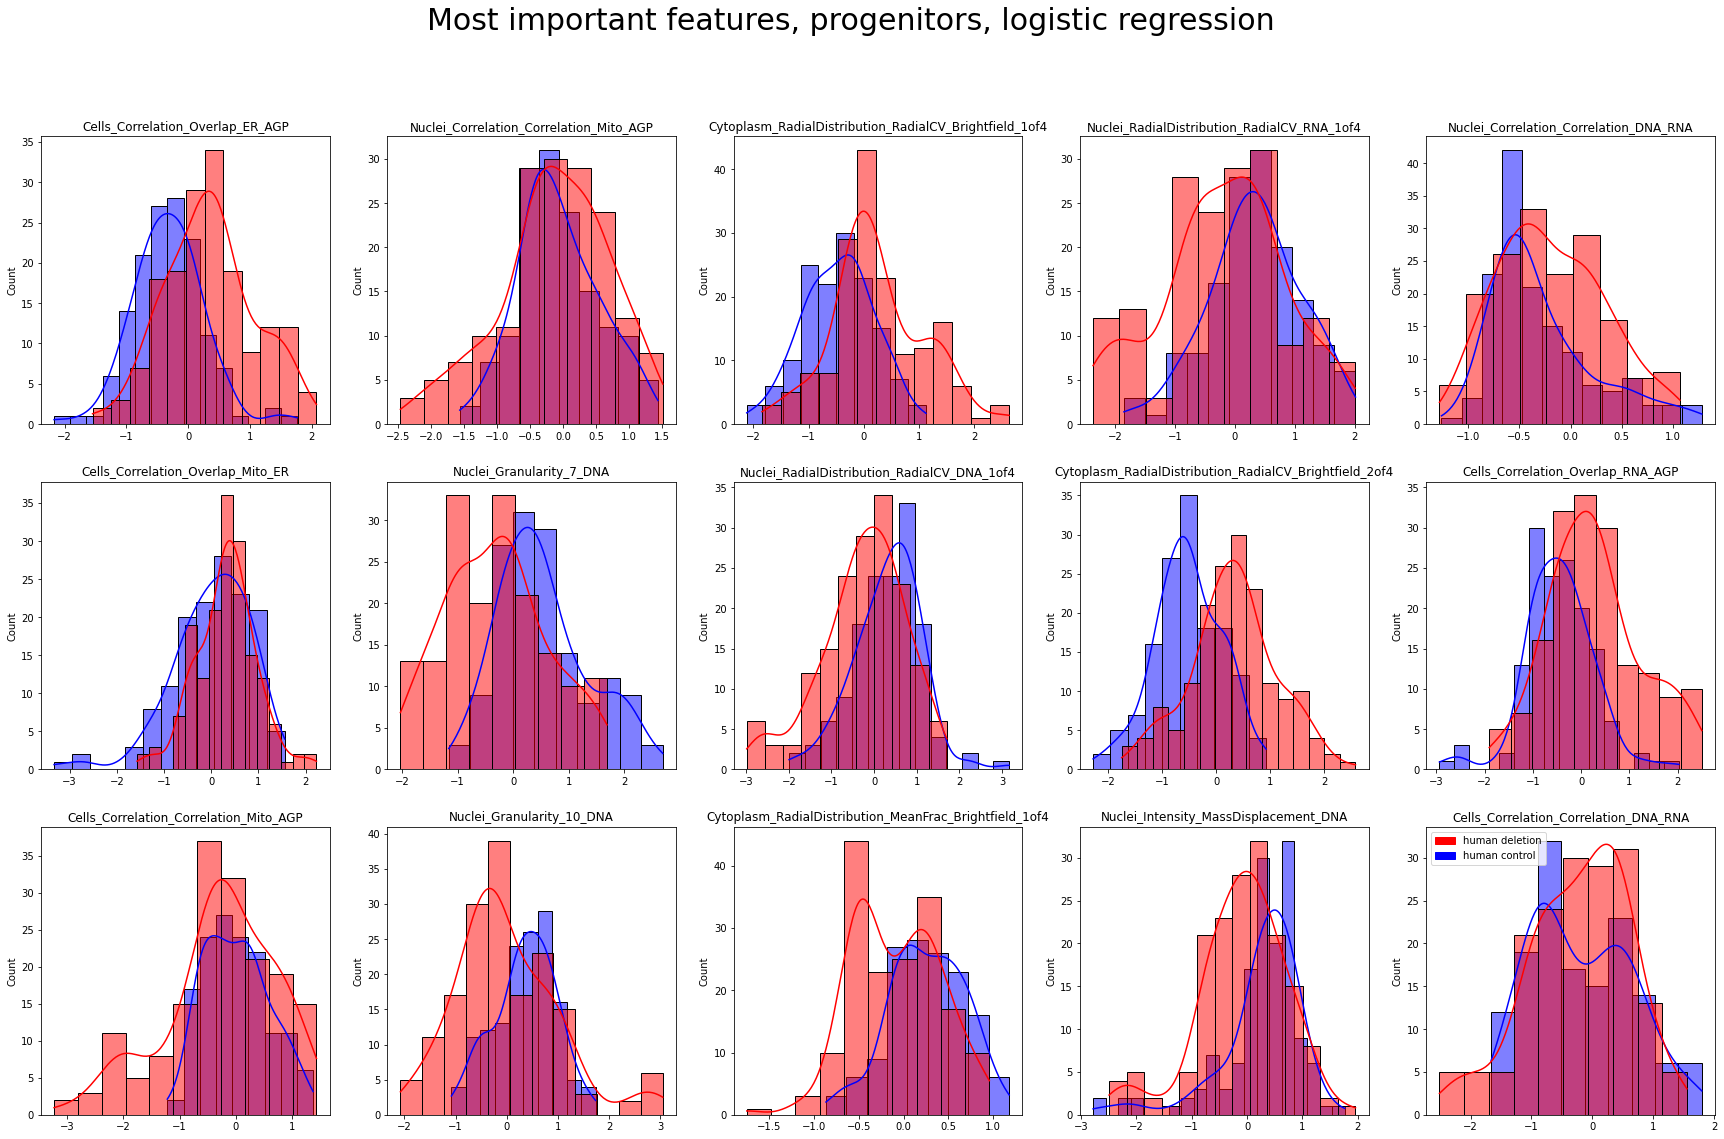

In [22]:
# Progenitors logistic

features = ['Cells_Correlation_Overlap_ER_AGP',
 'Nuclei_Correlation_Correlation_Mito_AGP',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_1of4',
 'Nuclei_Correlation_Correlation_DNA_RNA',
 'Cells_Correlation_Overlap_Mito_ER',
 'Nuclei_Granularity_7_DNA',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4',
 'Cells_Correlation_Overlap_RNA_AGP',
 'Cells_Correlation_Correlation_Mito_AGP',
 'Nuclei_Granularity_10_DNA',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4',
 'Nuclei_Intensity_MassDisplacement_DNA',
 'Cells_Correlation_Correlation_DNA_RNA']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    ctrl_vals = human_ctrl_df[[feature]]
    del_vals = human_del_df[[feature]]
    
    sns.histplot(np.ravel(ctrl_vals), kde=True, ax=axs[row, col], color='blue')
    sns.histplot(np.ravel(del_vals), kde=True, ax=axs[row, col], color='red')
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
        
plt.suptitle('Most important features, progenitors, logistic regression', size=30)
plt.legend(handles=[mpatches.Patch(color='red', label='human deletion'), 
           mpatches.Patch(color='blue', label='human control')])

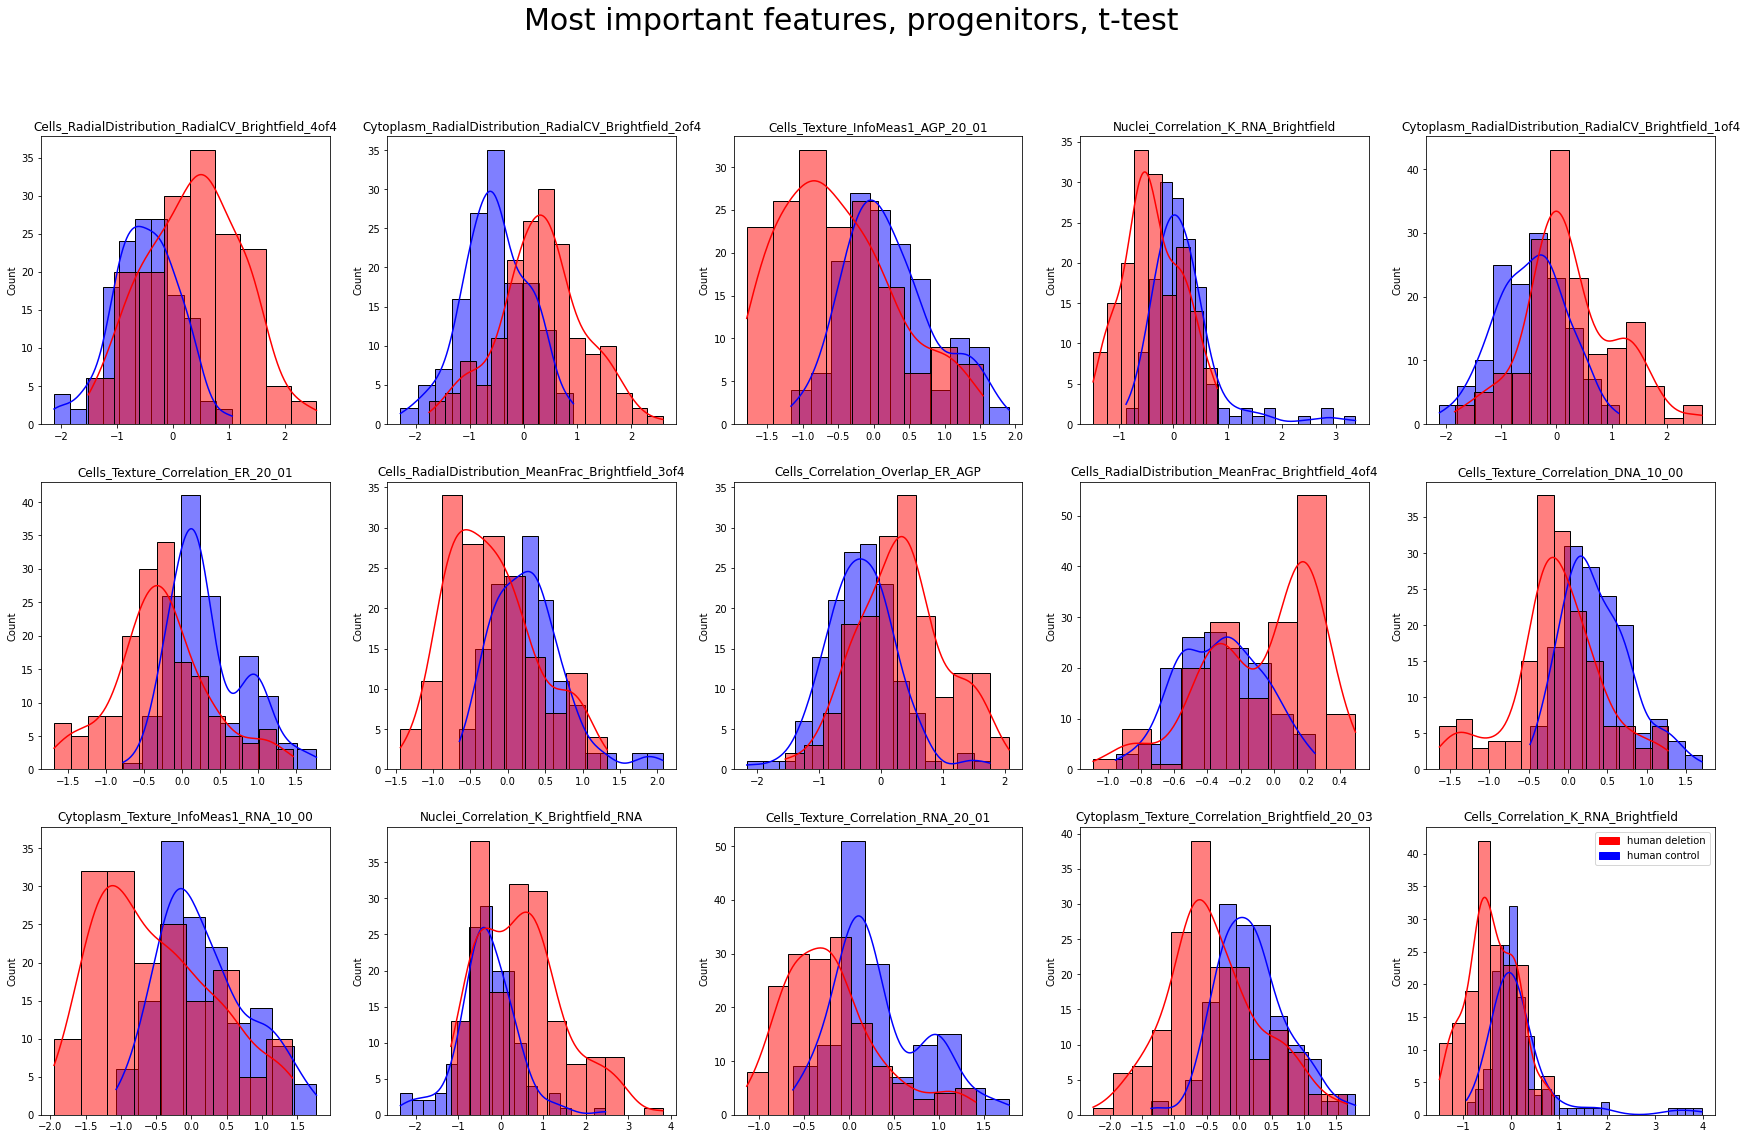

In [23]:
# Progenitors ttest

features = ['Cells_RadialDistribution_RadialCV_Brightfield_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4',
 'Cells_Texture_InfoMeas1_AGP_20_01',
 'Nuclei_Correlation_K_RNA_Brightfield',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Cells_Texture_Correlation_ER_20_01',
 'Cells_RadialDistribution_MeanFrac_Brightfield_3of4',
 'Cells_Correlation_Overlap_ER_AGP',
 'Cells_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Texture_Correlation_DNA_10_00',
 'Cytoplasm_Texture_InfoMeas1_RNA_10_00',
 'Nuclei_Correlation_K_Brightfield_RNA',
 'Cells_Texture_Correlation_RNA_20_01',
 'Cytoplasm_Texture_Correlation_Brightfield_20_03',
 'Cells_Correlation_K_RNA_Brightfield']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    ctrl_vals = human_ctrl_df[[feature]]
    del_vals = human_del_df[[feature]]
    
    sns.histplot(np.ravel(ctrl_vals), kde=True, ax=axs[row, col], color='blue')
    sns.histplot(np.ravel(del_vals), kde=True, ax=axs[row, col], color='red')
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
        
plt.suptitle('Most important features, progenitors, t-test', size=30)
plt.legend(handles=[mpatches.Patch(color='red', label='human deletion'), 
           mpatches.Patch(color='blue', label='human control')])

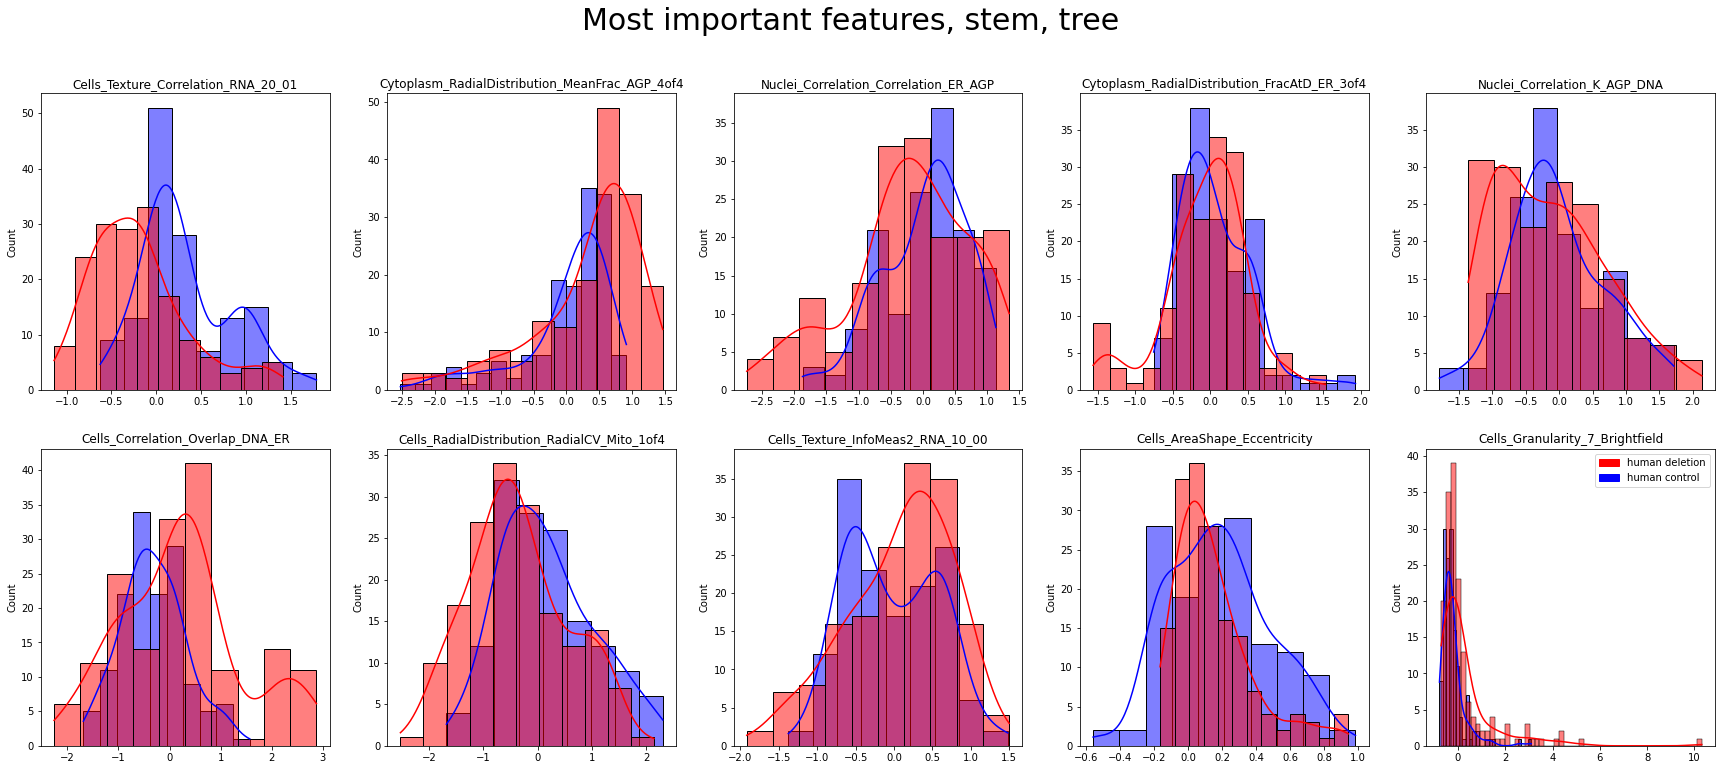

In [24]:
# Prog tree

features = ['Cells_Texture_Correlation_RNA_20_01',
 'Cytoplasm_RadialDistribution_MeanFrac_AGP_4of4',
 'Nuclei_Correlation_Correlation_ER_AGP',
 'Cytoplasm_RadialDistribution_FracAtD_ER_3of4',
 'Nuclei_Correlation_K_AGP_DNA',
 'Cells_Correlation_Overlap_DNA_ER',
 'Cells_RadialDistribution_RadialCV_Mito_1of4',
 'Cells_Texture_InfoMeas2_RNA_10_00',
 'Cells_AreaShape_Eccentricity',
 'Cells_Granularity_7_Brightfield']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(2,5, figsize=(30,12))
row = 0
col = 0
for feature in features:
    ctrl_vals = human_ctrl_df[[feature]]
    del_vals = human_del_df[[feature]]
    
    sns.histplot(np.ravel(ctrl_vals), kde=True, ax=axs[row, col], color='blue')
    sns.histplot(np.ravel(del_vals), kde=True, ax=axs[row, col], color='red')
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
        
plt.suptitle('Most important features, stem, tree', size=30)
plt.legend(handles=[mpatches.Patch(color='red', label='human deletion'), 
           mpatches.Patch(color='blue', label='human control')])

# Feature vs cell count/area

In [25]:
# Merge stem counts with stem
stem_cts = pd.read_csv(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_count.csv.gz', index_col=0)
stem = stem_orig
stem['well'] = stem.index.str.split('_').map(lambda x: x[-1])
stem['idx'] = stem.index
stem = stem.merge(stem_cts, how='inner', left_on='well', right_on='Metadata_Well').drop(['well', 'Metadata_Well'], axis=1)
stem.set_index('idx', inplace=True)

In [26]:
# Merge progenitors with cell_number_object_number
progenitors = progenitors_orig.copy()
prog_cts = pd.read_csv(base_dir + '/1.run-workflows/profiles/NCP_PROGENITORS_1/BR_NCP_PROGENITORS_1.csv.gz', index_col=0)
prog_cts = prog_cts[['Metadata_Well', 'Cells_Number_Object_Number']]

progenitors['well'] = progenitors.index.str.split('_').map(lambda x: x[-1])
progenitors['well'] = progenitors.index.str.split('_').map(lambda x: x[-1])
progenitors['idx'] = progenitors.index
progenitors = progenitors.merge(prog_cts, how='inner', left_on='well', right_on='Metadata_Well').drop(['well', 'Metadata_Well'], axis=1)
progenitors.set_index('idx', inplace=True)

Text(0.5, 0.98, 'Most important features, stem, logistic regression')

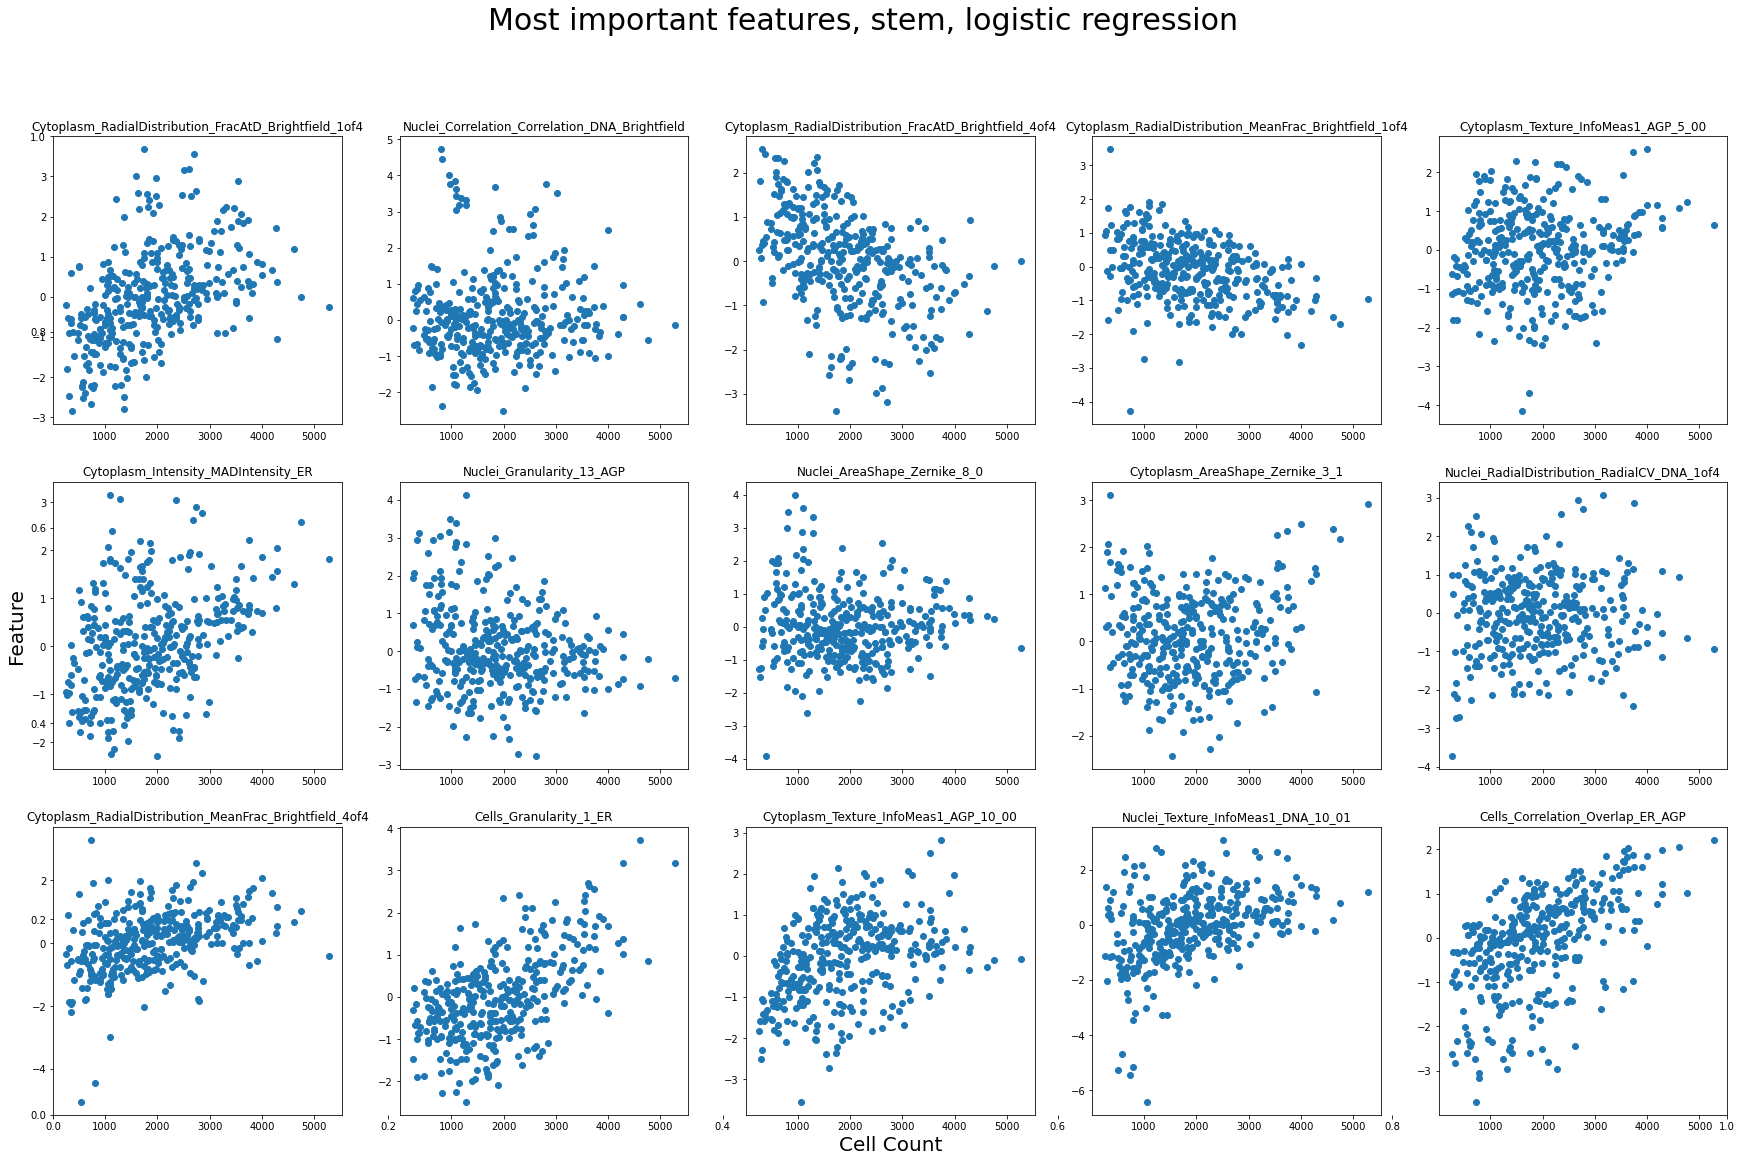

In [27]:
# Stem logistic

features = ['Cytoplasm_RadialDistribution_FracAtD_Brightfield_1of4',
 'Nuclei_Correlation_Correlation_DNA_Brightfield',
 'Cytoplasm_RadialDistribution_FracAtD_Brightfield_4of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4',
 'Cytoplasm_Texture_InfoMeas1_AGP_5_00',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Nuclei_Granularity_13_AGP',
 'Nuclei_AreaShape_Zernike_8_0',
 'Cytoplasm_AreaShape_Zernike_3_1',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Granularity_1_ER',
 'Cytoplasm_Texture_InfoMeas1_AGP_10_00',
 'Nuclei_Texture_InfoMeas1_DNA_10_01',
 'Cells_Correlation_Overlap_ER_AGP']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(stem['Count_Cells'], stem[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Cell Count', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, stem, logistic regression', size=30)


Text(0.5, 0.98, 'Most important features, stem, t-test')

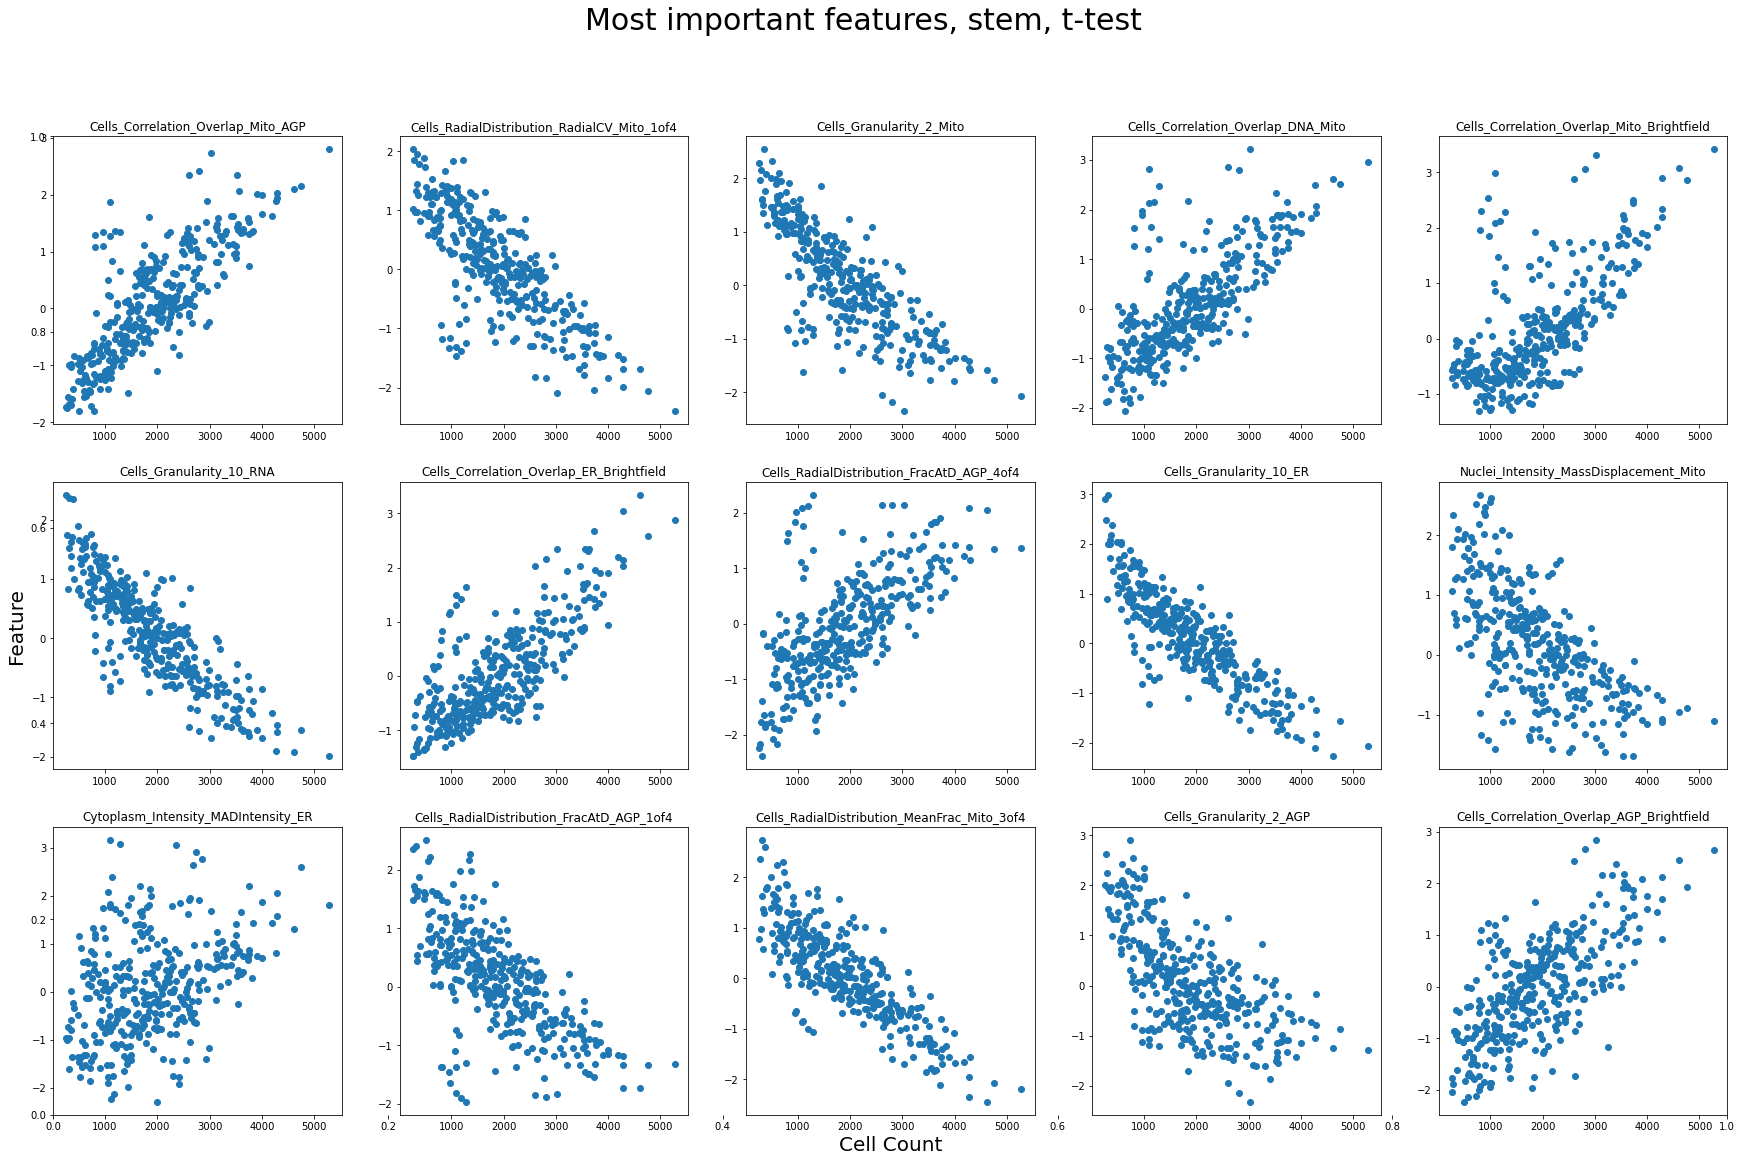

In [28]:
# Stem t-test

features = ['Cells_Correlation_Overlap_Mito_AGP',
 'Cells_RadialDistribution_RadialCV_Mito_1of4',
 'Cells_Granularity_2_Mito',
 'Cells_Correlation_Overlap_DNA_Mito',
 'Cells_Correlation_Overlap_Mito_Brightfield',
 'Cells_Granularity_10_RNA',
 'Cells_Correlation_Overlap_ER_Brightfield',
 'Cells_RadialDistribution_FracAtD_AGP_4of4',
 'Cells_Granularity_10_ER',
 'Nuclei_Intensity_MassDisplacement_Mito',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Cells_RadialDistribution_FracAtD_AGP_1of4',
 'Cells_RadialDistribution_MeanFrac_Mito_3of4',
 'Cells_Granularity_2_AGP',
 'Cells_Correlation_Overlap_AGP_Brightfield']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(stem['Count_Cells'], stem[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Cell Count', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, stem, t-test', size=30)

Text(0.5, 0.98, 'Most important features, stem, logistic regression')

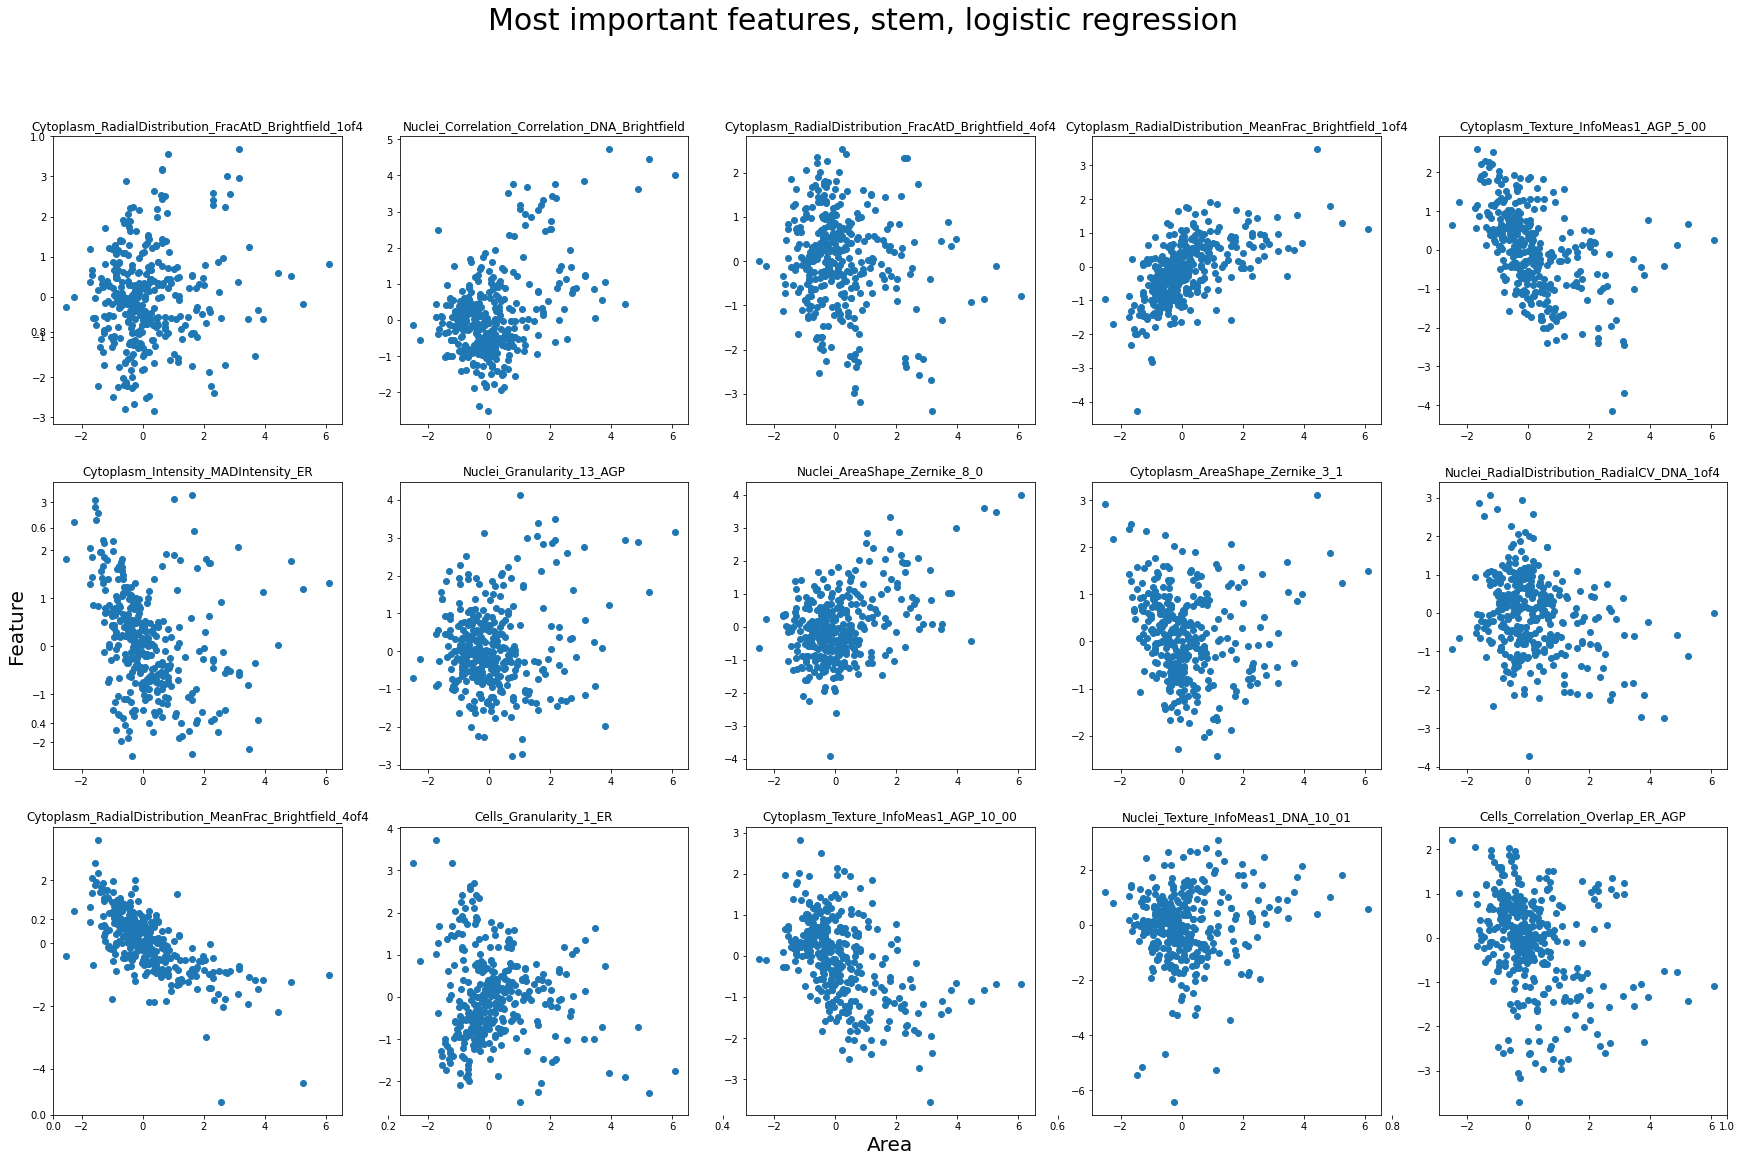

In [29]:
# Stem logistic

features = ['Cytoplasm_RadialDistribution_FracAtD_Brightfield_1of4',
 'Nuclei_Correlation_Correlation_DNA_Brightfield',
 'Cytoplasm_RadialDistribution_FracAtD_Brightfield_4of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4',
 'Cytoplasm_Texture_InfoMeas1_AGP_5_00',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Nuclei_Granularity_13_AGP',
 'Nuclei_AreaShape_Zernike_8_0',
 'Cytoplasm_AreaShape_Zernike_3_1',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Granularity_1_ER',
 'Cytoplasm_Texture_InfoMeas1_AGP_10_00',
 'Nuclei_Texture_InfoMeas1_DNA_10_01',
 'Cells_Correlation_Overlap_ER_AGP']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(stem['Cells_AreaShape_Area'], stem[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Area', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, stem, logistic regression', size=30)

Text(0.5, 0.98, 'Most important features, stem, t-test')

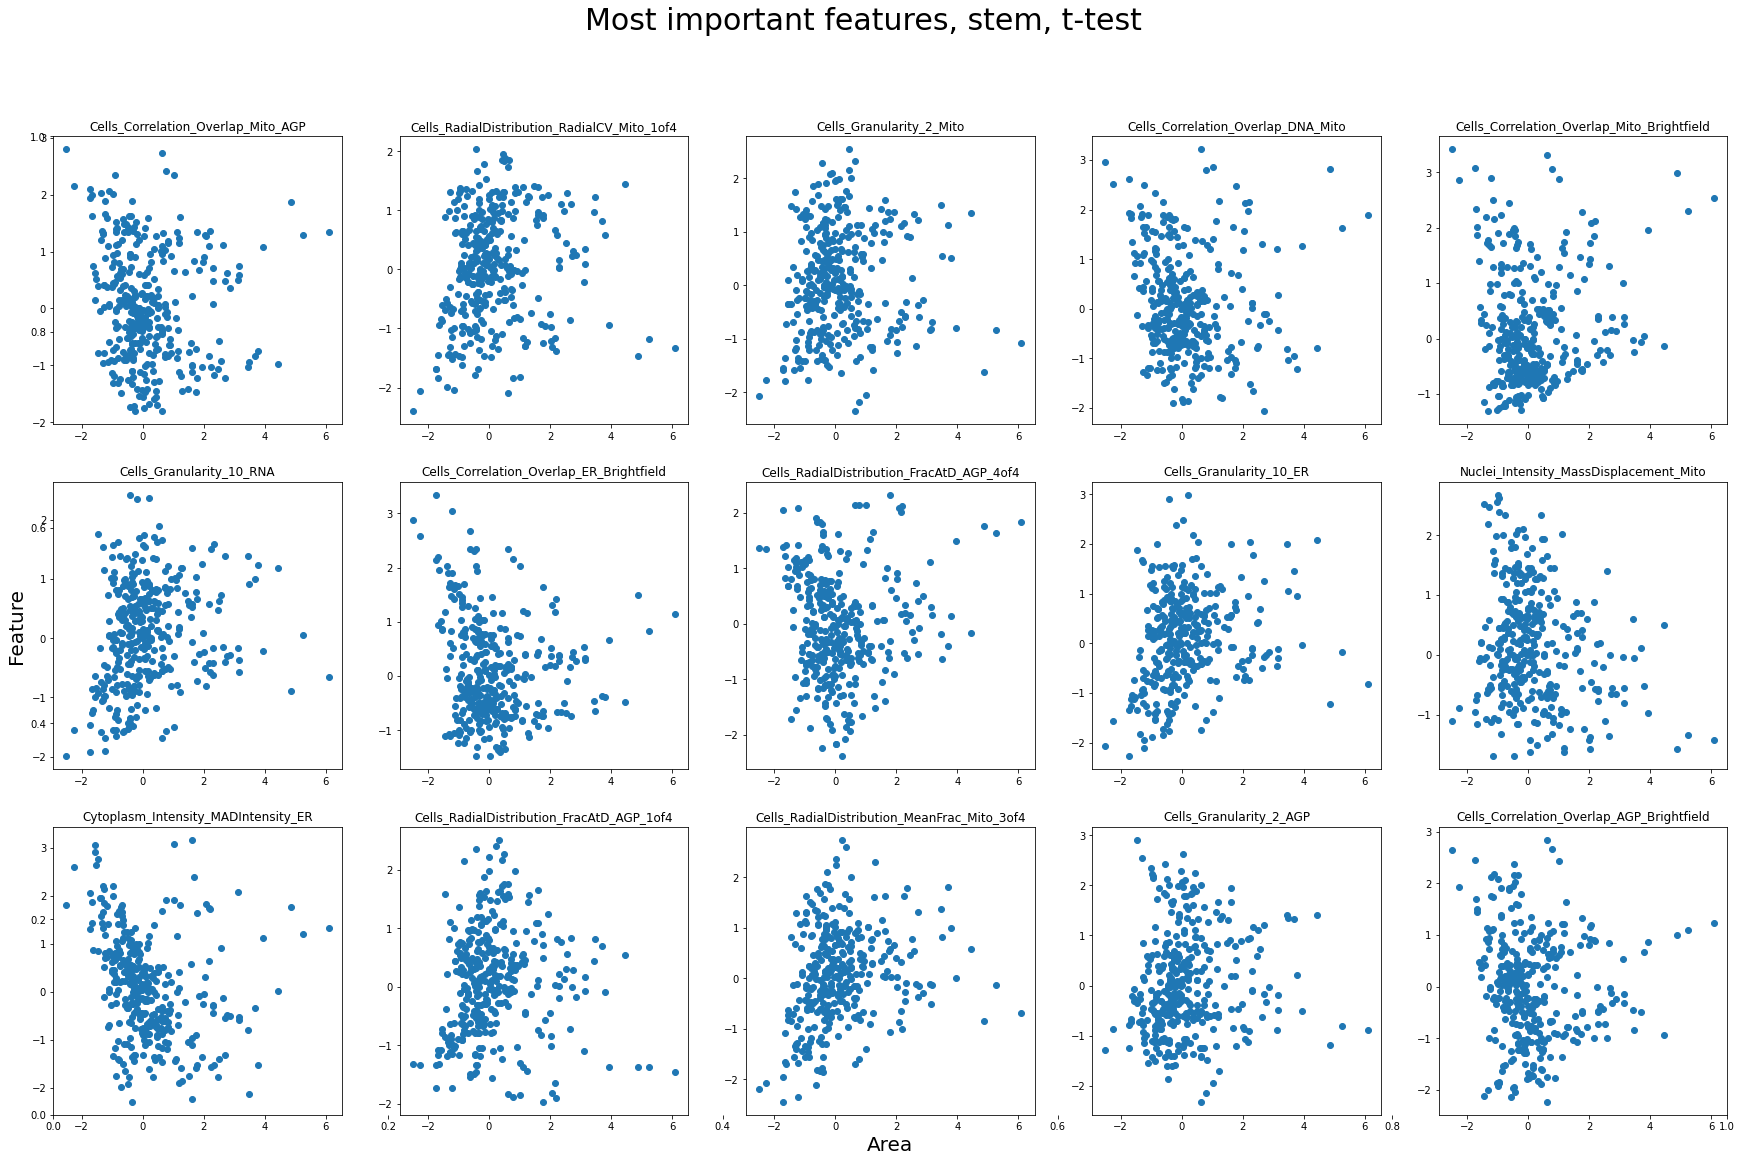

In [30]:
# Stem t-test

features = ['Cells_Correlation_Overlap_Mito_AGP',
 'Cells_RadialDistribution_RadialCV_Mito_1of4',
 'Cells_Granularity_2_Mito',
 'Cells_Correlation_Overlap_DNA_Mito',
 'Cells_Correlation_Overlap_Mito_Brightfield',
 'Cells_Granularity_10_RNA',
 'Cells_Correlation_Overlap_ER_Brightfield',
 'Cells_RadialDistribution_FracAtD_AGP_4of4',
 'Cells_Granularity_10_ER',
 'Nuclei_Intensity_MassDisplacement_Mito',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Cells_RadialDistribution_FracAtD_AGP_1of4',
 'Cells_RadialDistribution_MeanFrac_Mito_3of4',
 'Cells_Granularity_2_AGP',
 'Cells_Correlation_Overlap_AGP_Brightfield']

human_ctrl_df = stem[stem.index.str.contains('human_control')]
human_del_df = stem[stem.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(stem['Cells_AreaShape_Area'], stem[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Area', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, stem, t-test', size=30)

Text(0.5, 0.98, 'Most important features, progenitors, logistic regression')

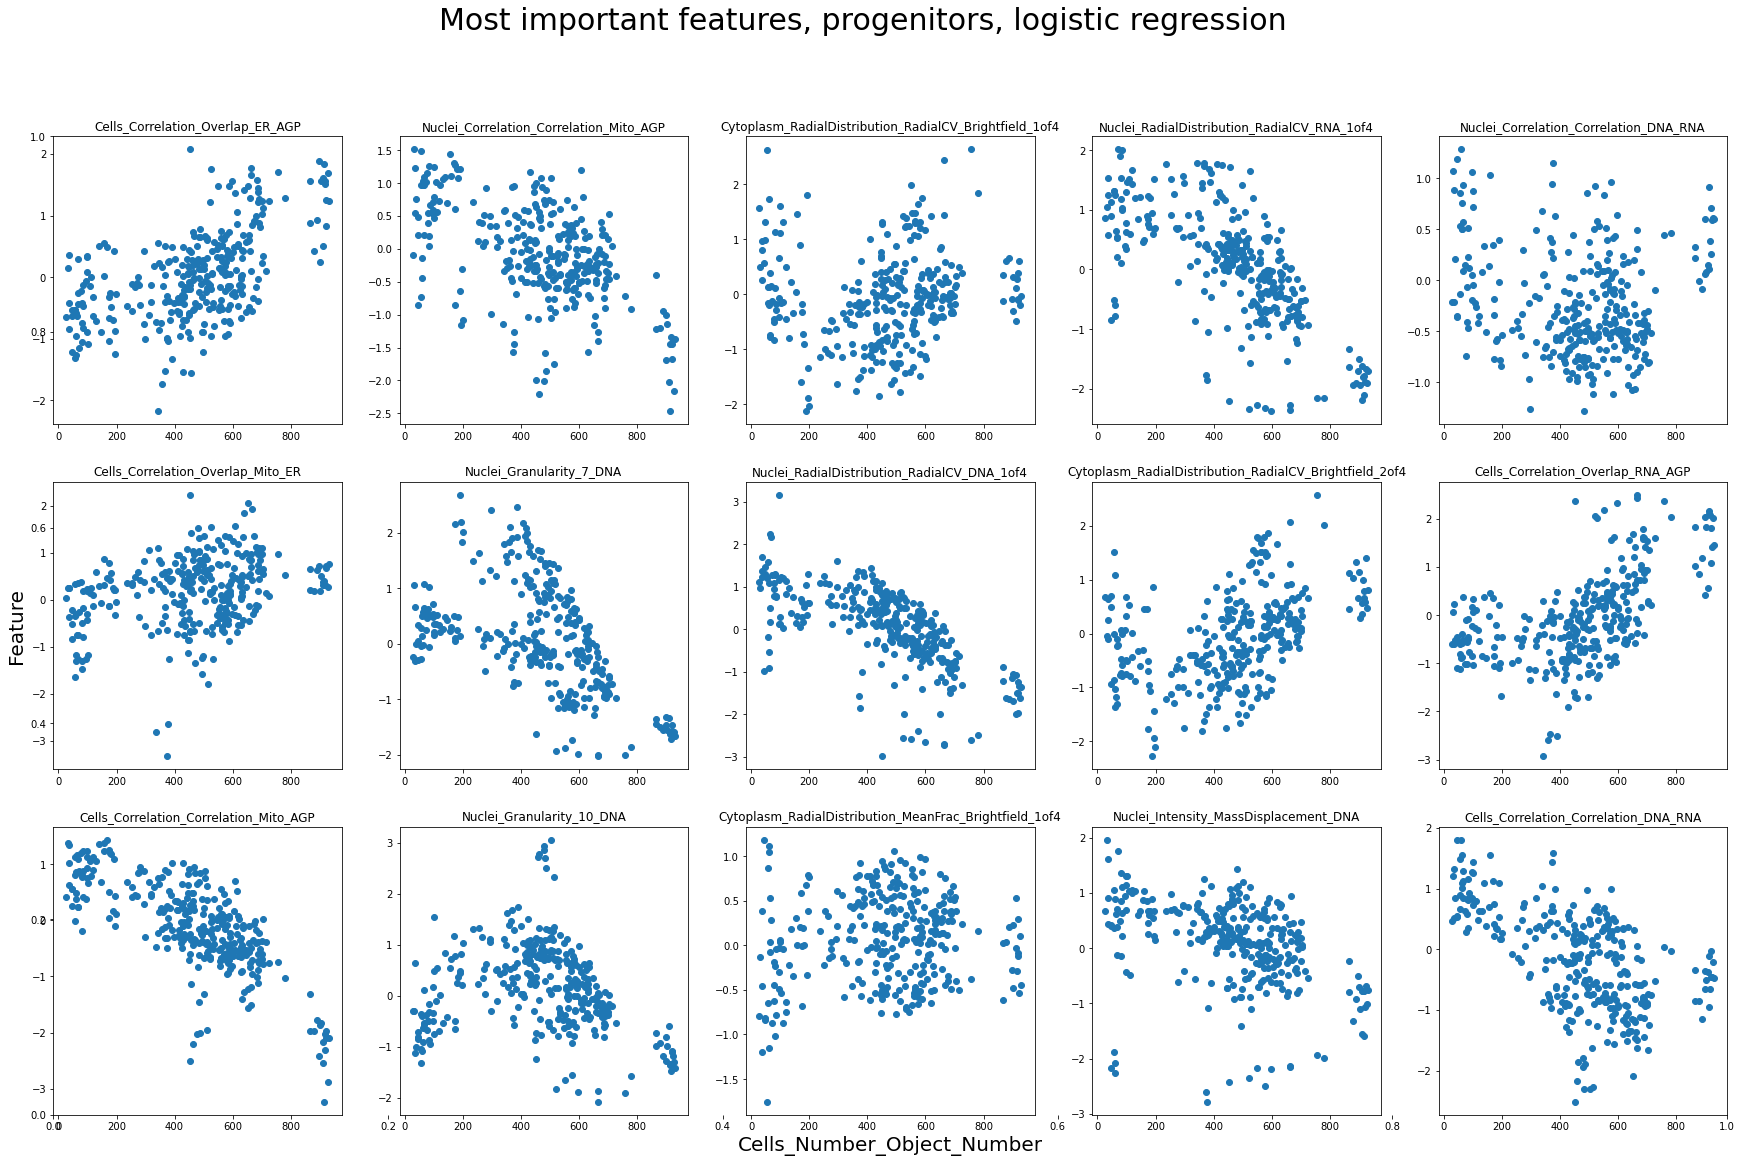

In [31]:
# Prog logistic count

features = ['Cells_Correlation_Overlap_ER_AGP',
 'Nuclei_Correlation_Correlation_Mito_AGP',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_1of4',
 'Nuclei_Correlation_Correlation_DNA_RNA',
 'Cells_Correlation_Overlap_Mito_ER',
 'Nuclei_Granularity_7_DNA',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4',
 'Cells_Correlation_Overlap_RNA_AGP',
 'Cells_Correlation_Correlation_Mito_AGP',
 'Nuclei_Granularity_10_DNA',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4',
 'Nuclei_Intensity_MassDisplacement_DNA',
 'Cells_Correlation_Correlation_DNA_RNA']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(progenitors['Cells_Number_Object_Number'], progenitors[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Cells_Number_Object_Number', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, progenitors, logistic regression', size=30)

Text(0.5, 0.98, 'Most important features, progenitors, t-test')

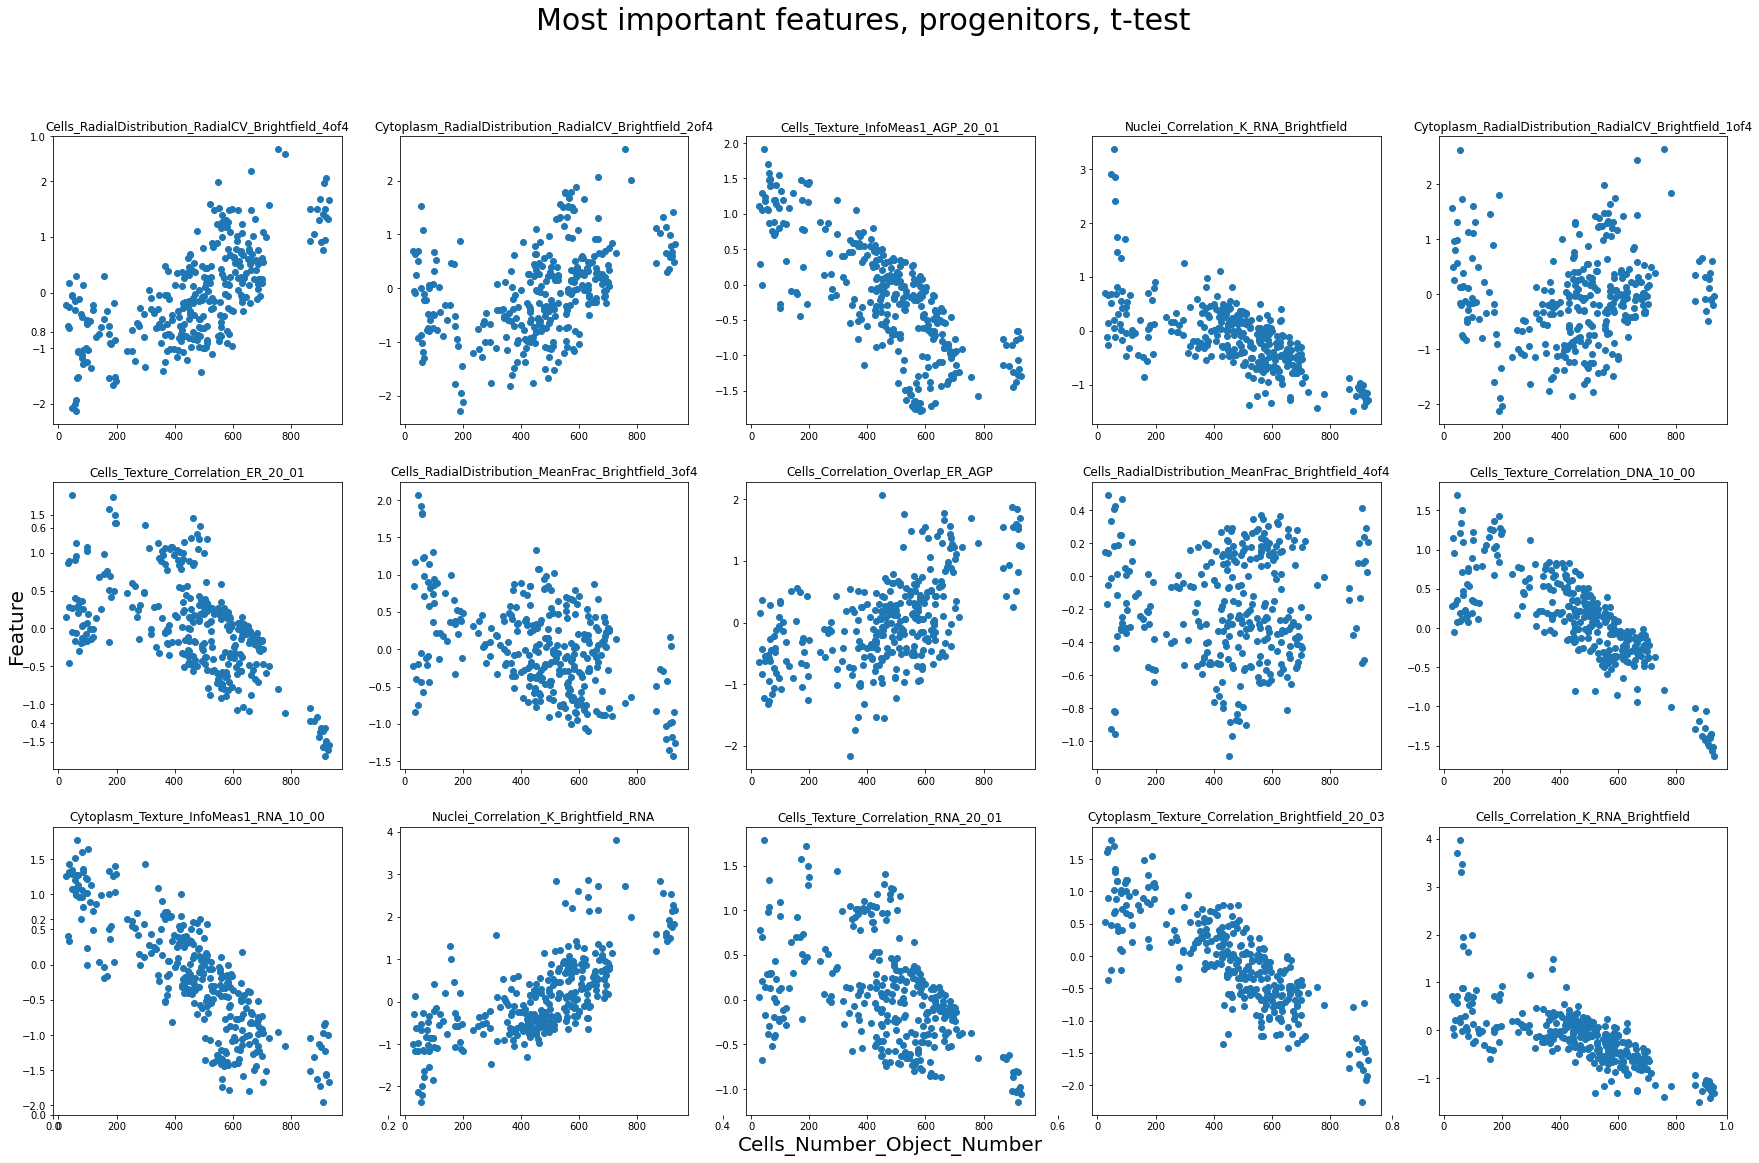

In [32]:
# Prog t-test count

features = ['Cells_RadialDistribution_RadialCV_Brightfield_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4',
 'Cells_Texture_InfoMeas1_AGP_20_01',
 'Nuclei_Correlation_K_RNA_Brightfield',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Cells_Texture_Correlation_ER_20_01',
 'Cells_RadialDistribution_MeanFrac_Brightfield_3of4',
 'Cells_Correlation_Overlap_ER_AGP',
 'Cells_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Texture_Correlation_DNA_10_00',
 'Cytoplasm_Texture_InfoMeas1_RNA_10_00',
 'Nuclei_Correlation_K_Brightfield_RNA',
 'Cells_Texture_Correlation_RNA_20_01',
 'Cytoplasm_Texture_Correlation_Brightfield_20_03',
 'Cells_Correlation_K_RNA_Brightfield']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(progenitors['Cells_Number_Object_Number'], progenitors[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Cells_Number_Object_Number', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, progenitors, t-test', size=30)

Text(0.5, 0.98, 'Most important features, progenitors, logistic regression')

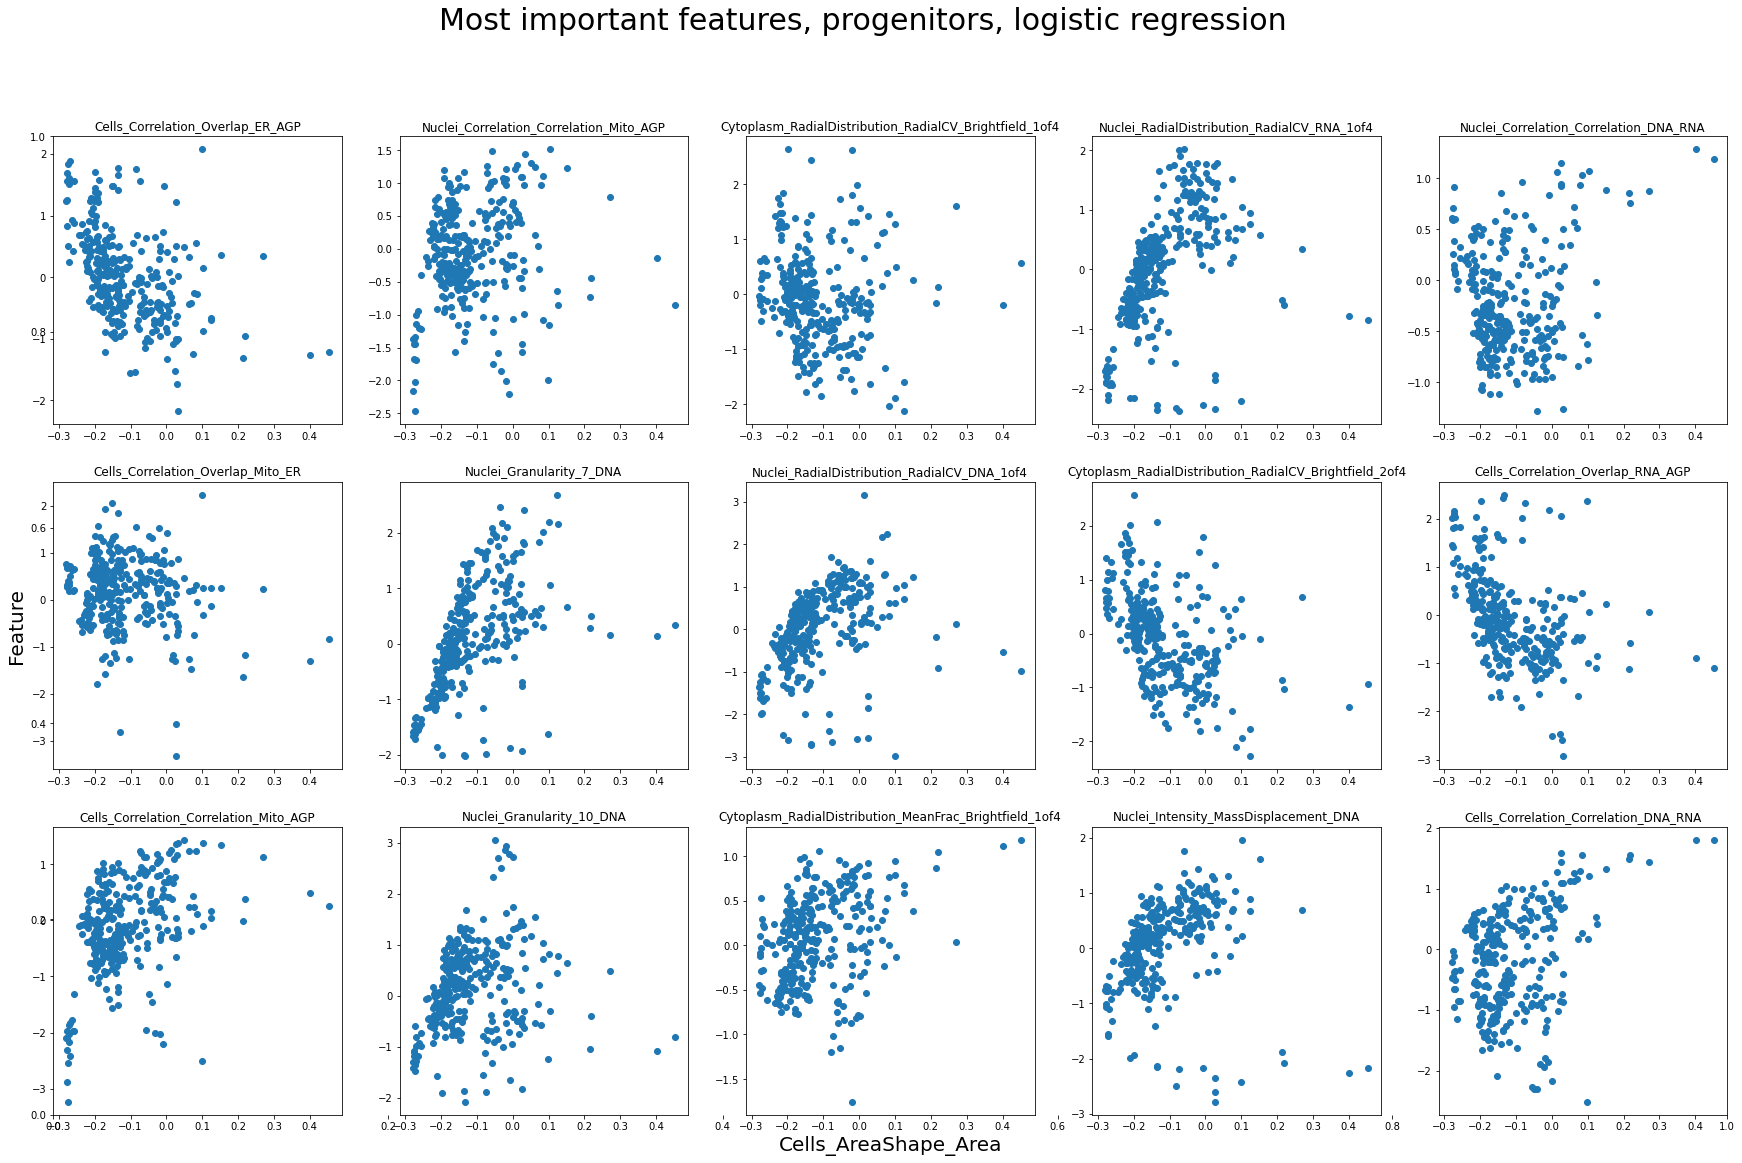

In [33]:
# Prog logistic Area

features = ['Cells_Correlation_Overlap_ER_AGP',
 'Nuclei_Correlation_Correlation_Mito_AGP',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_1of4',
 'Nuclei_Correlation_Correlation_DNA_RNA',
 'Cells_Correlation_Overlap_Mito_ER',
 'Nuclei_Granularity_7_DNA',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4',
 'Cells_Correlation_Overlap_RNA_AGP',
 'Cells_Correlation_Correlation_Mito_AGP',
 'Nuclei_Granularity_10_DNA',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_1of4',
 'Nuclei_Intensity_MassDisplacement_DNA',
 'Cells_Correlation_Correlation_DNA_RNA']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(progenitors['Cells_AreaShape_Area'], progenitors[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Cells_AreaShape_Area', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, progenitors, logistic regression', size=30)

Text(0.5, 0.98, 'Most important features, progenitors, t-test')

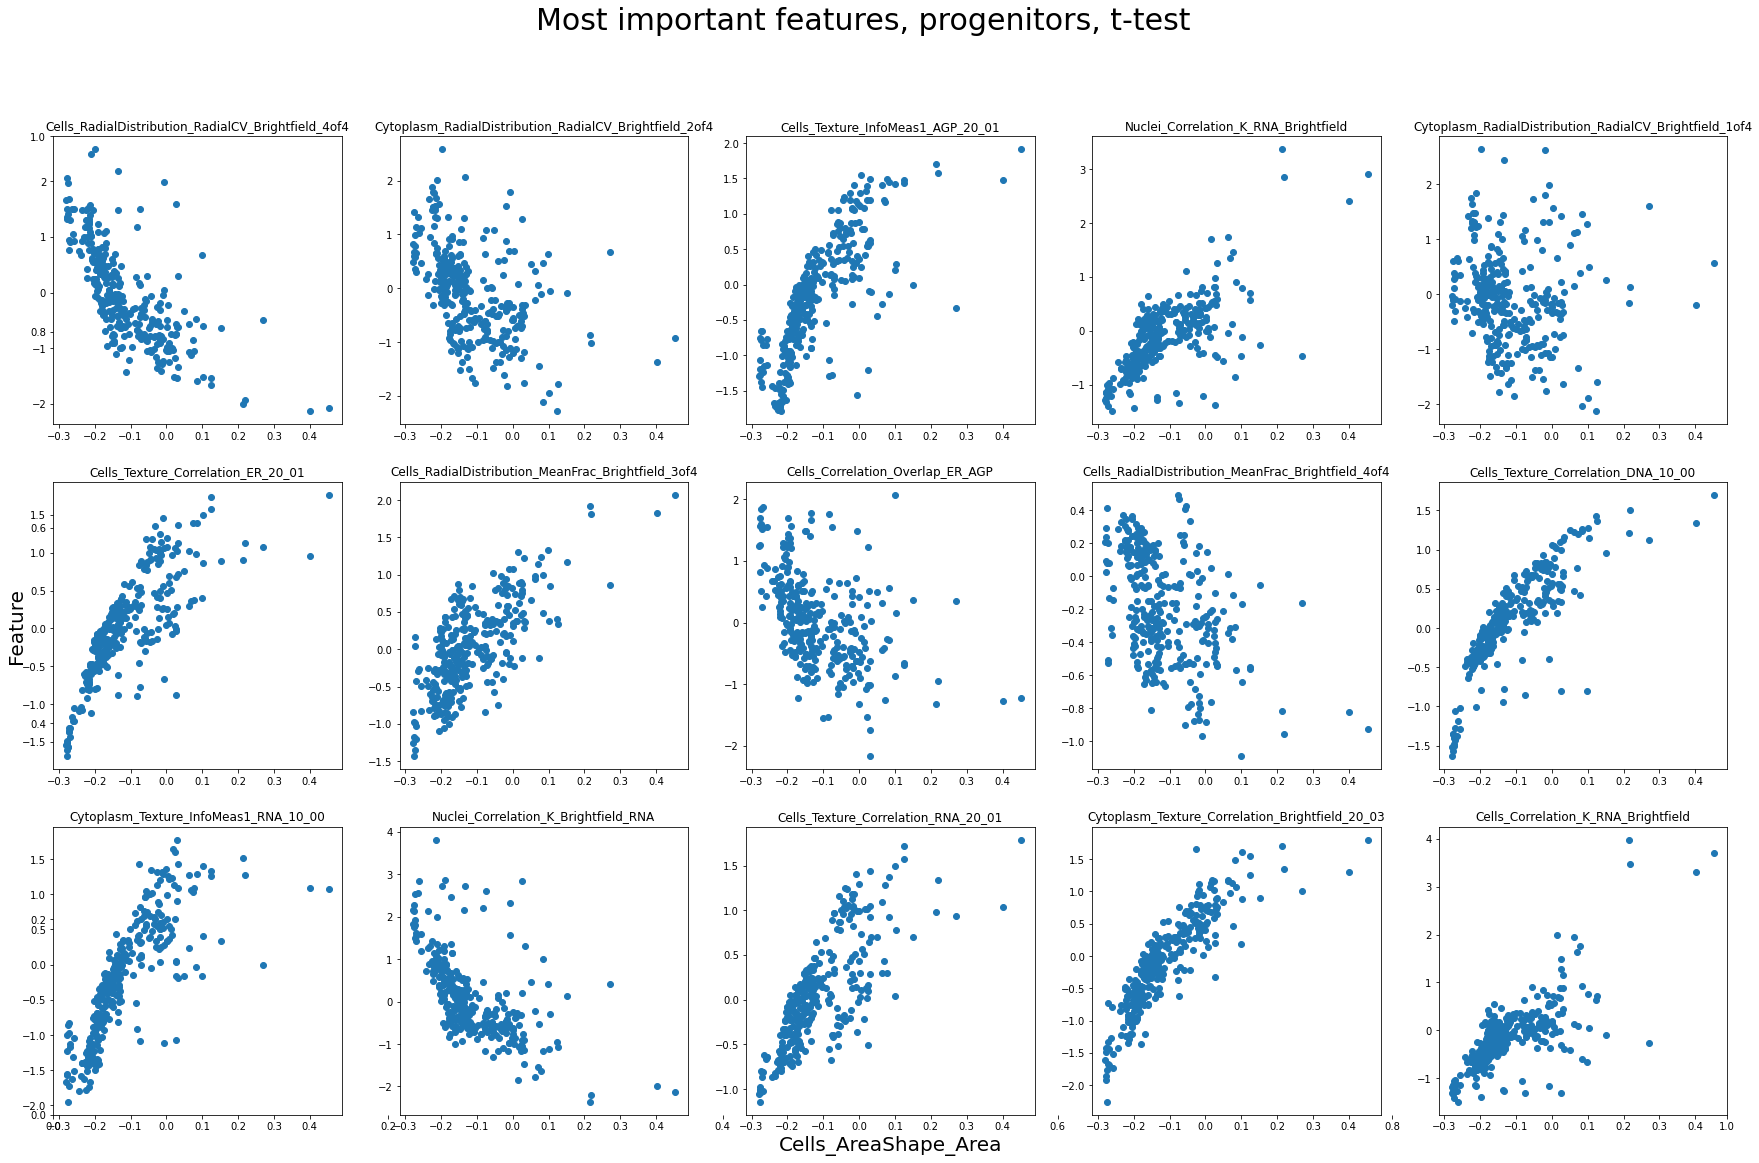

In [34]:
# Prog t-test area

features = ['Cells_RadialDistribution_RadialCV_Brightfield_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_2of4',
 'Cells_Texture_InfoMeas1_AGP_20_01',
 'Nuclei_Correlation_K_RNA_Brightfield',
 'Cytoplasm_RadialDistribution_RadialCV_Brightfield_1of4',
 'Cells_Texture_Correlation_ER_20_01',
 'Cells_RadialDistribution_MeanFrac_Brightfield_3of4',
 'Cells_Correlation_Overlap_ER_AGP',
 'Cells_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Texture_Correlation_DNA_10_00',
 'Cytoplasm_Texture_InfoMeas1_RNA_10_00',
 'Nuclei_Correlation_K_Brightfield_RNA',
 'Cells_Texture_Correlation_RNA_20_01',
 'Cytoplasm_Texture_Correlation_Brightfield_20_03',
 'Cells_Correlation_K_RNA_Brightfield']

human_ctrl_df = progenitors[progenitors.index.str.contains('human_control')]
human_del_df = progenitors[progenitors.index.str.contains('human_deletion')]

fig, axs = plt.subplots(3,5, figsize=(30,18))
row = 0
col = 0
for feature in features:
    axs[row, col].scatter(progenitors['Cells_AreaShape_Area'], progenitors[feature])
    axs[row, col].set_title(feature)
    if col != 4:
        col += 1
    else:
        row += 1
        col = 0
fig.add_subplot(111, frameon=False)
plt.xlabel('Cells_AreaShape_Area', size=20)
plt.ylabel('Feature', size=20)
plt.suptitle('Most important features, progenitors, t-test', size=30)

In [35]:
progenitors[['Cells_AreaShape_Area', 'Cells_Number_Object_Number']].sort_values(by='Cells_AreaShape_Area', ascending=False).head(20)

,Cells_AreaShape_Area,Cells_Number_Object_Number
idx,,
human_control_21_P12,0.452629,46.075000
human_control_21_P11,0.401567,60.686093
human_deletion_41_F04,0.270232,99.568710
human_control_21_O11,0.218784,61.067779
human_control_21_O12,0.214243,57.288398
human_deletion_41_K05,0.151179,36.553398
human_control_10_O01,0.125020,173.012666
human_control_10_P01,0.124413,188.471542
human_deletion_41_L05,0.102911,31.954819


In [36]:
progenitors[['Cells_AreaShape_Area', 'Cells_Number_Object_Number']].sort_values(by='Cells_AreaShape_Area', ascending=False).tail(20)

,Cells_AreaShape_Area,Cells_Number_Object_Number
idx,,
human_deletion_44_I06,-0.234905,618.277221
human_deletion_36_M03,-0.235404,615.703264
human_deletion_36_M04,-0.237476,634.695457
human_deletion_36_N04,-0.243341,654.444713
human_deletion_34_A11,-0.256708,865.426171
human_deletion_34_B11,-0.257031,865.330440
human_deletion_34_N16,-0.261005,878.765224
human_deletion_34_N15,-0.264227,889.277037
human_deletion_38_C15,-0.268734,897.694825
